In [1]:
# packages
import os
import gc
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc, f1_score, mean_squared_error, accuracy_score, mean_squared_error,log_loss
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset

In [2]:
torch.__version__

'2.0.1'

In [3]:
EPOCHS = 2000
LR = 1e-3
BS = 32
SEED = 42
MODEL_NAME ='model'
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(SEED) # Seed 고정

In [4]:
device = torch.device('cpu') if torch.backends.mps.is_available() else torch.device('cpu')
print(device)

cpu


In [5]:
df = pd.read_csv('./raw_data.csv')
df

,EQUIP_ID,MFG_DT,SALE_CD,MOLD_POS,REAL_POWER,CP,AX,MOLD_IN_TOP,MOLD_IN_BOT,MOLD_OUT_TOP,MOLD_OUT_BOT,IN_RADIUS,OUT_RADIUS,POWER,POWER1,POWER2,POWER3,POWER4,POWER5
0,EQUIP1,2021-03-23,SALES 0,8,0.00,NaN,NaN,CORE1 A 02. 0570,CORE1 A 01. P3+3,CORE1 A 05. M0075,CORE1 A 8A. D-00,-6.4889,6.5811,0.00,0.12,0.12,0.12,0.25,0.25
1,EQUIP2,2021-03-23,SALES 1,1,-6.50,NaN,NaN,CORE1 B 02. 0550,CORE1 B 01. P2+1,CORE1 B 02. M1050,CORE1 B 02. C-10,-6.3564,7.4551,-6.50,-6.25,-6.25,-6.37,-6.50,-6.50
2,EQUIP1,2021-03-25,SALES 2,2,0.00,NaN,NaN,CORE2 C 03. 0660,CORE2 C 03. P1+0,CORE2 C 04. M0000,CORE2 C 04. A-00,-7.3246,7.3802,0.00,0.12,0.12,0.25,0.25,0.25
3,EQUIP2,2021-03-25,SALES 3,6,-7.50,NaN,NaN,CORE1 B 02. 0550,CORE1 B 01. P2+1,CORE1 B 02. M1250,CORE1 B 02. C-12,-6.3600,7.6877,-7.50,-7.50,-7.50,-7.62,-7.62,-7.62
4,EQUIP3,2021-04-09,SALES 4,1,-0.75,NaN,NaN,CORE3 C 01. 0660,CORE3 C 01. OK+2,CORE3 C 03. M0125,CORE3 C 03. B-01,-7.3411,7.5236,-0.75,-0.87,-0.87,-0.87,-0.87,-0.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175097,EQUIP13,2020-10-13,SALES 114,4,-5.25,NaN,NaN,CORE5 F 01. 0570,CORE5 F 01. OK+0,CORE5 F 02. M0850,CORE5 F 02. C-08,-6.3304,7.1881,-5.25,-5.25,-5.25,-5.25,-5.25,-5.25
175098,EQUIP13,2020-10-14,SALES 114,5,-5.25,NaN,NaN,CORE5 F 01. 0570,CORE5 F 01. OK+2,CORE5 F 02. M0875,CORE5 F 02. D-08,-6.4933,6.8071,-5.25,-5.12,-5.12,-5.25,-5.25,-5.25
175099,EQUIP13,2020-10-16,SALES 114,6,-5.50,NaN,NaN,CORE5 F 01. 0570,CORE5 F 01. OK+1,CORE5 F 02. M0950,CORE5 F 02. C-09,-6.3582,0.0000,-5.50,-5.37,-5.37,-5.50,-5.50,-5.50
175100,EQUIP35,2020-10-14,SALES 114,7,-8.00,NaN,NaN,CORE5 F 01. 0570,CORE5 F 01. P1+0,CORE5 F 02. M1350,CORE5 F 02. C-13,-6.3056,7.7866,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print(df['MOLD_IN_TOP'].value_counts())
print(df['MOLD_IN_BOT'].value_counts())
print(df['MOLD_OUT_TOP'].value_counts())
print(df['MOLD_OUT_BOT'].value_counts())

MOLD_IN_TOP
CORE1 A 02. 0570    68090
CORE1 B 02. 0550    52320
CORE2 C 03. 0660    25794
CORE3 C 01. 0660    14370
CORE4 D 01. 0565     6220
CORE5 E 01. 0590     4442
CORE5 F 01. 0570     2260
CORE7 G 01. 0600      544
CORE2 J 03. 0650      480
CORE1 H 03. 0580      249
CORE2 K 01. 0670      197
CORE8 J 01. 0650       95
CORE7 I 01. 0610       32
CORE8 L 1-1 0630        9
Name: count, dtype: int64
MOLD_IN_BOT
CORE1 B 01. P2+1    16288
CORE1 A 01. P3+3    11767
CORE1 A 01. P2+3    10129
CORE1 A 01. P3+2     9956
CORE1 A 01. P2+2     9726
                    ...  
CORE2 J 01. M3+2        1
CORE2 J 01. OK+3        1
CORE4 D 01. OK+3        1
CORE8 J 01. M1+2        1
CORE5 F 01. OK+4        1
Name: count, Length: 221, dtype: int64
MOLD_OUT_TOP
CORE1 A 05. M0075    4185
CORE2 C 04. M0025    3604
CORE1 A 05. M0250    3371
CORE1 A 05. M0050    2847
CORE1 A 05. M0300    2792
                     ... 
CORE2 C 04. M1500       1
CORE1 A 05. P0100       1
CORE1 A 08. P0700       1
CORE8 J 02. M0

In [7]:
df.isnull().sum()

EQUIP_ID             0
MFG_DT               0
SALE_CD              0
MOLD_POS             0
REAL_POWER          13
CP              175102
AX              175102
MOLD_IN_TOP          0
MOLD_IN_BOT          0
MOLD_OUT_TOP         0
MOLD_OUT_BOT         0
IN_RADIUS            0
OUT_RADIUS           0
POWER              580
POWER1             530
POWER2             532
POWER3             537
POWER4             540
POWER5             551
dtype: int64

In [8]:
df_dropna = df.drop(['CP','AX','SALE_CD'],axis=1)

new_df = df_dropna.loc[df['REAL_POWER'] == df['POWER']].dropna(axis=0)
anomaly_df = df_dropna.loc[df['REAL_POWER'] != df['POWER']].dropna(axis=0)

new_df = new_df.loc[new_df['REAL_POWER'] < 0]
anomaly_df = anomaly_df.loc[anomaly_df['REAL_POWER'] < 0]

new_df = new_df.loc[new_df['POWER'] < 0]
anomaly_df = anomaly_df.loc[anomaly_df['POWER'] < 0]

new_df['MFG_DT'] = pd.to_datetime(new_df['MFG_DT'])
anomaly_df['MFG_DT'] = pd.to_datetime(anomaly_df['MFG_DT'])

new_df = new_df[new_df['MFG_DT'] >= np.datetime64('2020-01-01')]
anomlay_df = anomaly_df[anomaly_df['MFG_DT'] >= np.datetime64('2020-01-01')]

new_df = new_df.drop('MFG_DT', axis = 1)
anomaly_df = anomaly_df.drop('MFG_DT', axis=1)


new_df = new_df.loc[new_df['POWER'] > -20].dropna(axis=0)
anomaly_df = anomaly_df.loc[anomaly_df['POWER'] > -20].dropna(axis=0)



new_df['IN_RADIUS'] = abs(new_df['IN_RADIUS'])
new_df['OUT_RADIUS'] = abs(new_df['OUT_RADIUS'])
anomaly_df['IN_RADIUS'] = abs(anomaly_df['IN_RADIUS'])
anomaly_df['OUT_RADIUS'] = abs(anomaly_df['OUT_RADIUS'])
print(new_df.shape)
print(anomaly_df.shape)

(28607, 15)
(557, 15)


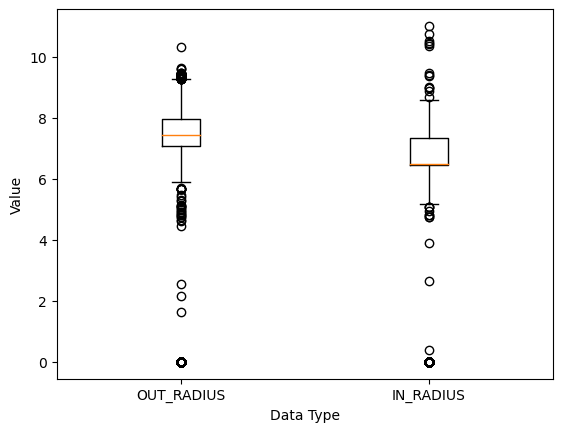

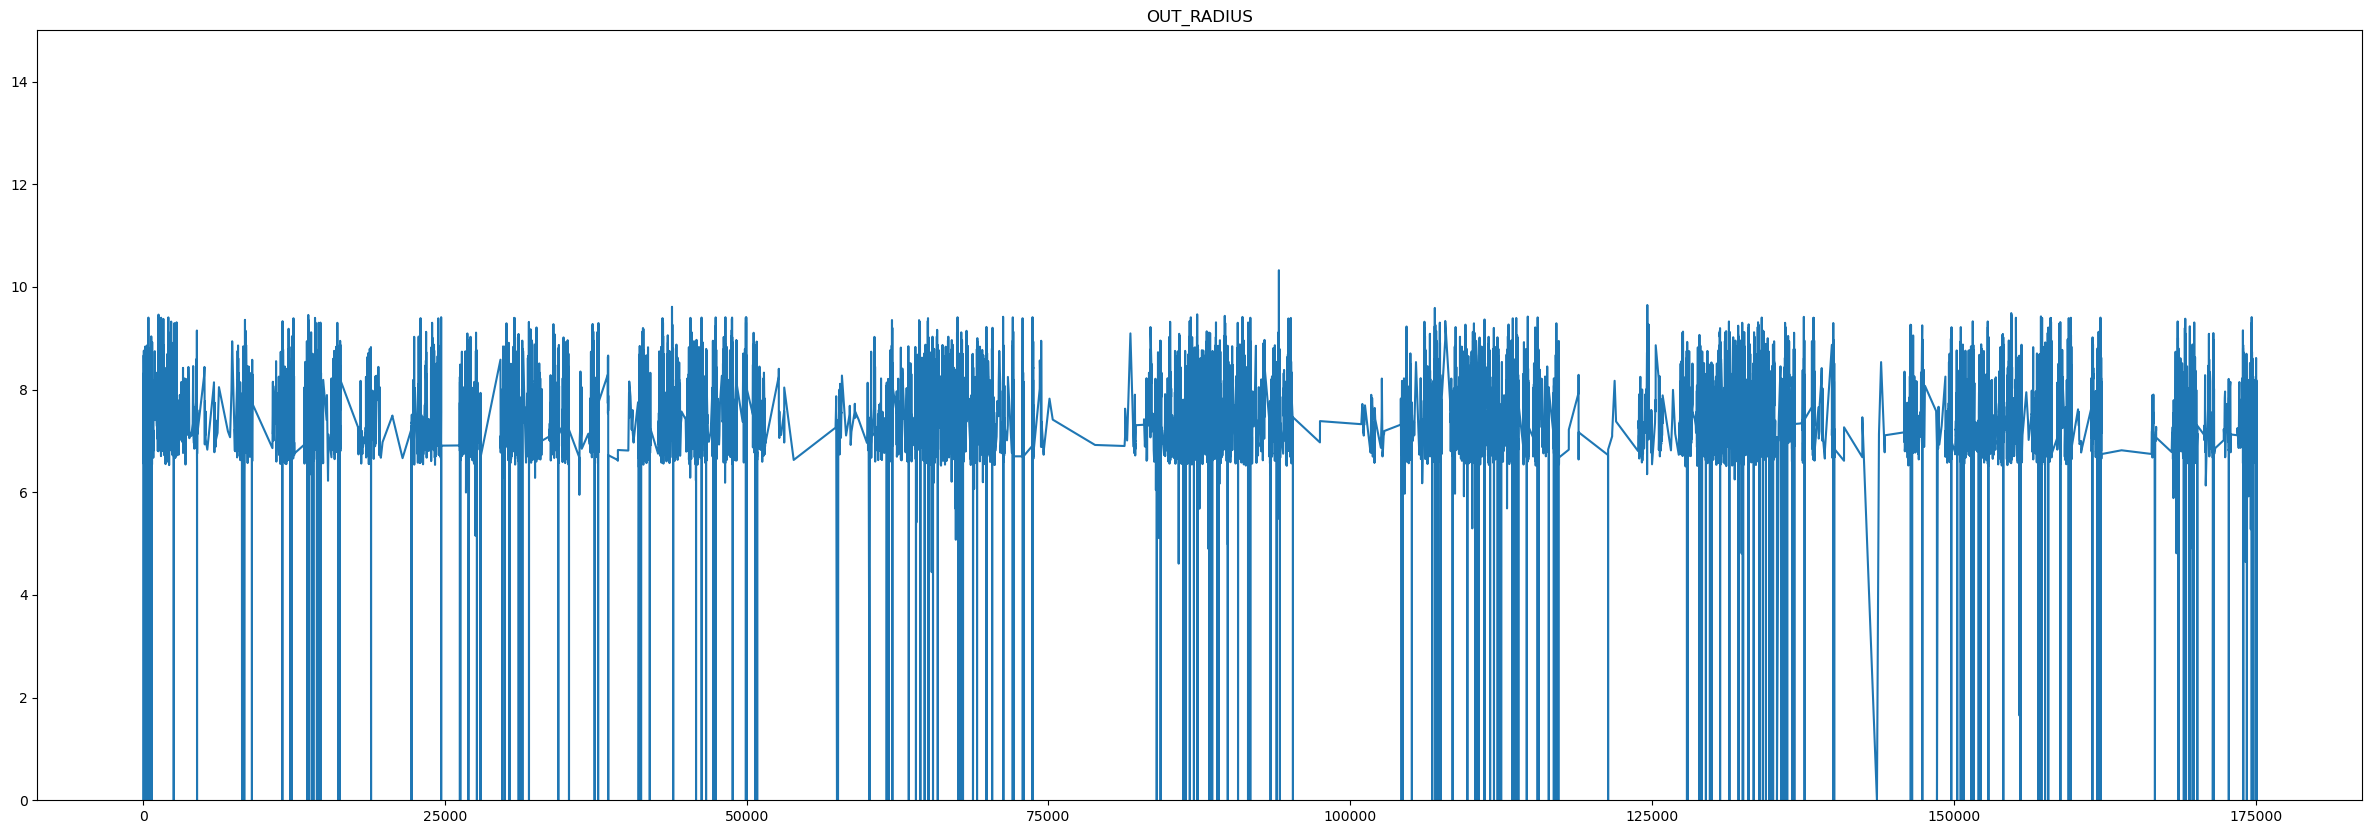

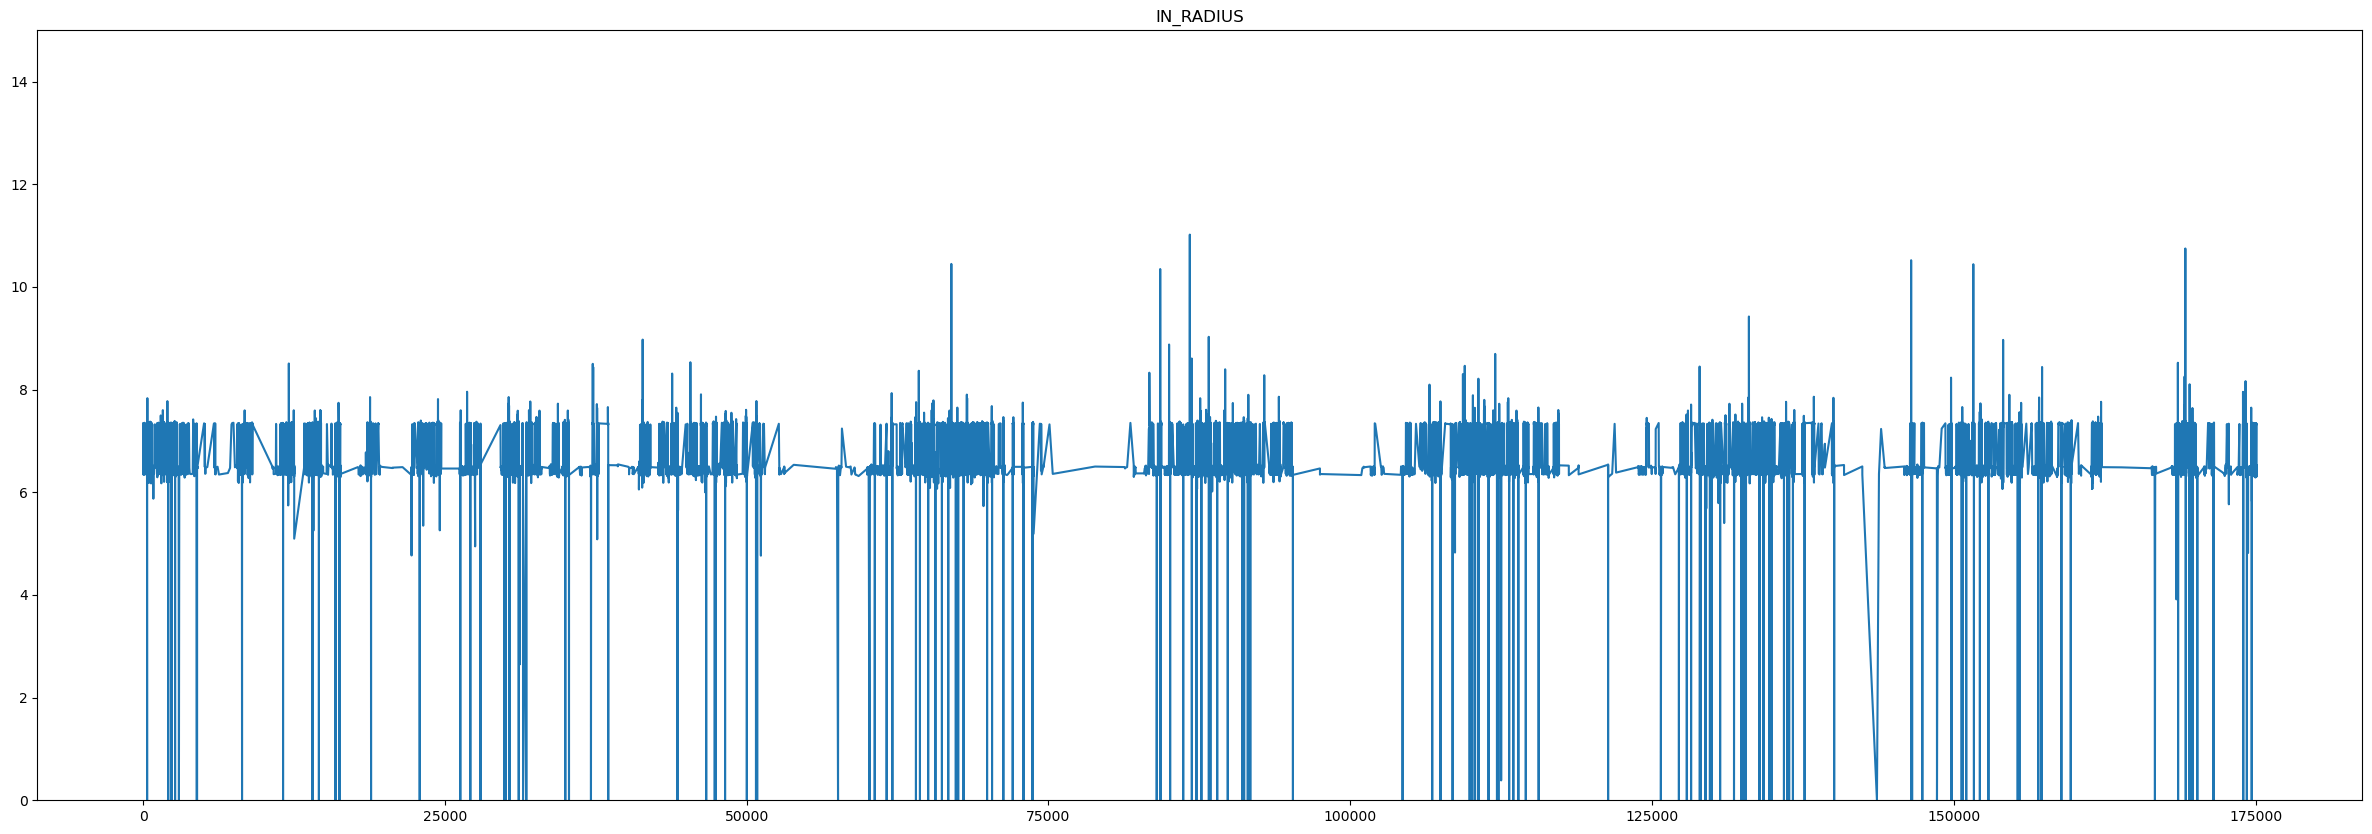

In [9]:
fig, ax = plt.subplots()

ax.boxplot([new_df['OUT_RADIUS'], new_df['IN_RADIUS']])
ax.set_xlabel('Data Type')
ax.set_ylabel('Value')
plt.xticks([1, 2], ['OUT_RADIUS','IN_RADIUS'])
plt.show()

plt.figure(figsize=(30,10))
plt.plot(new_df['OUT_RADIUS'])
plt.title('OUT_RADIUS')
plt.ylim([0,15])
plt.show()

plt.figure(figsize=(30,10))
plt.plot(new_df['IN_RADIUS'])
plt.title('IN_RADIUS')
plt.ylim([0,15])
plt.show()

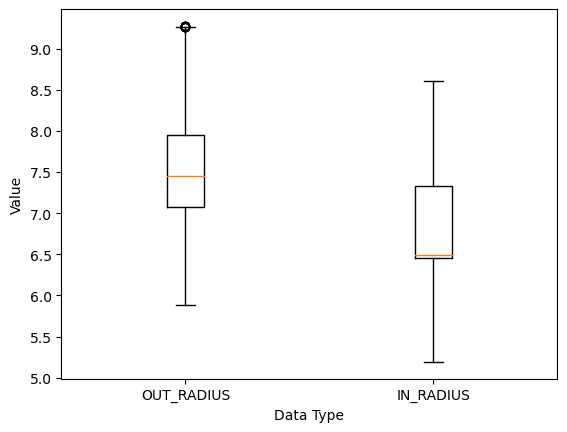

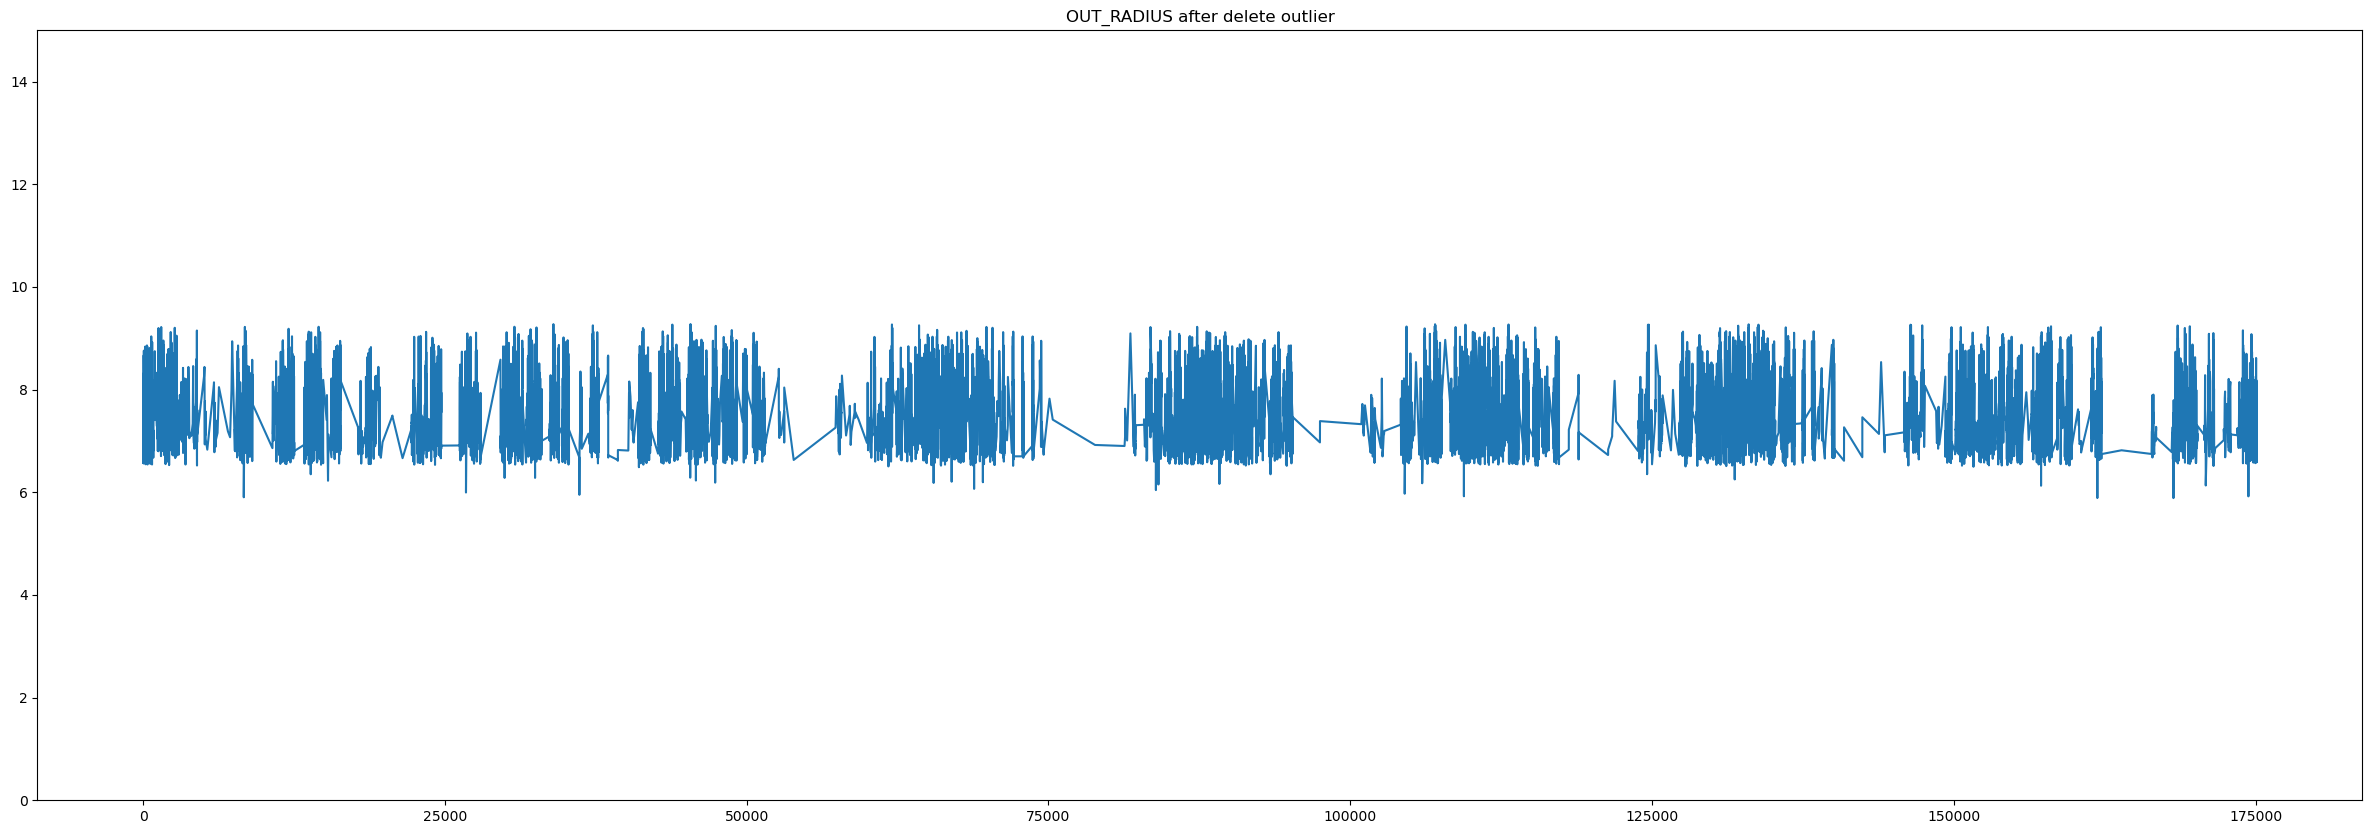

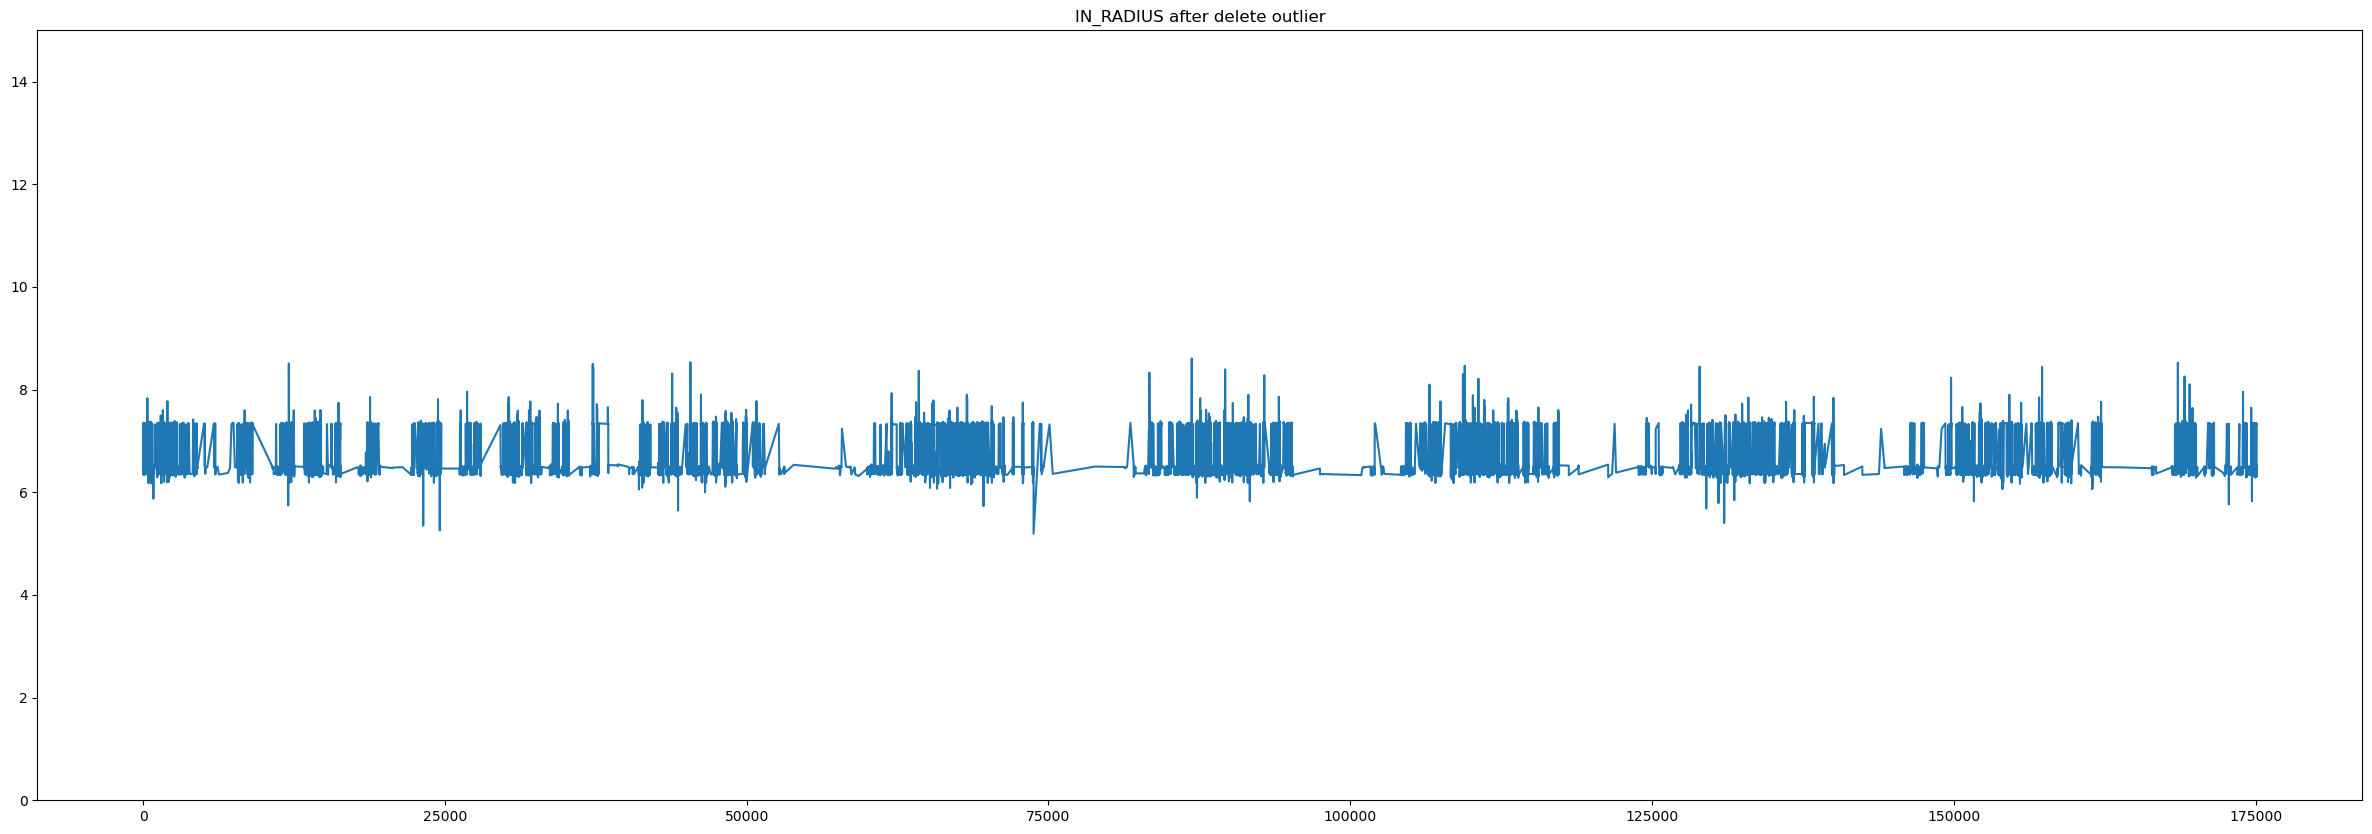

In [10]:
def get_outlier(df=None, column=None, weight=1.5):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight
  
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
  
    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    return outlier_idx

# 함수 사용해서 이상치 값 삭제
outlier_idx_in_rad = get_outlier(df=new_df, column='IN_RADIUS', weight=1.5)
new_df = new_df.drop(outlier_idx_in_rad,axis=0)
outlier_idx_out_rad = get_outlier(df=new_df, column='OUT_RADIUS', weight=1.5)
new_df = new_df.drop(outlier_idx_out_rad,axis=0)

outlier_idx_in_rad = get_outlier(df=anomaly_df, column='IN_RADIUS', weight=1.5)
anomaly_df = anomaly_df.drop(outlier_idx_in_rad,axis=0)
outlier_idx_out_rad = get_outlier(df=anomaly_df, column='OUT_RADIUS', weight=1.5)
anomaly_df = anomaly_df.drop(outlier_idx_out_rad,axis=0)

fig, ax = plt.subplots()

ax.boxplot([new_df['OUT_RADIUS'], new_df['IN_RADIUS']])
ax.set_xlabel('Data Type')
ax.set_ylabel('Value')
plt.xticks([1, 2], ['OUT_RADIUS','IN_RADIUS'])
plt.show()

plt.figure(figsize=(30,10))
plt.plot(new_df['OUT_RADIUS'])
plt.title('OUT_RADIUS after delete outlier')
plt.ylim([0,15])
plt.show()

plt.figure(figsize=(30,10))
plt.plot(new_df['IN_RADIUS'])
plt.title('IN_RADIUS after delete outlier')
plt.ylim([0,15])
plt.show()

In [11]:
new_df['target'] = 0
anomaly_df['target'] = 1

In [12]:
new_df

,EQUIP_ID,MOLD_POS,REAL_POWER,MOLD_IN_TOP,MOLD_IN_BOT,MOLD_OUT_TOP,MOLD_OUT_BOT,IN_RADIUS,OUT_RADIUS,POWER,POWER1,POWER2,POWER3,POWER4,POWER5,target
1,EQUIP2,1,-6.50,CORE1 B 02. 0550,CORE1 B 01. P2+1,CORE1 B 02. M1050,CORE1 B 02. C-10,6.3564,7.4551,-6.50,-6.25,-6.25,-6.37,-6.50,-6.50,0
3,EQUIP2,6,-7.50,CORE1 B 02. 0550,CORE1 B 01. P2+1,CORE1 B 02. M1250,CORE1 B 02. C-12,6.3600,7.6877,-7.50,-7.50,-7.50,-7.62,-7.62,-7.62,0
4,EQUIP3,1,-0.75,CORE3 C 01. 0660,CORE3 C 01. OK+2,CORE3 C 03. M0125,CORE3 C 03. B-01,7.3411,7.5236,-0.75,-0.87,-0.87,-0.87,-0.87,-0.87,0
5,EQUIP4,8,-4.00,CORE1 A 02. 0570,CORE1 A 01. P1+2,CORE1 A 05. M0650,CORE1 A 08. C-06,6.4829,7.1508,-4.00,-4.00,-3.87,-3.87,-4.12,-4.12,0
6,EQUIP5,6,-8.50,CORE1 A 02. 0570,CORE1 A 01. P3+2,CORE1 A 05. M1550,CORE1 A 08. C-15,6.4800,8.2939,-8.50,-8.25,-8.25,-8.37,-8.37,-8.37,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175095,EQUIP37,1,-4.00,CORE5 F 01. 0570,CORE5 F 01. OK+1,CORE5 F 02. M0675,CORE5 F 02. D-06,6.3326,6.9997,-4.00,-4.12,-4.12,-4.00,-4.00,-4.00,0
175096,EQUIP37,8,-4.75,CORE5 F 01. 0570,CORE5 F 01. OK+2,CORE5 F 02. M0775,CORE5 F 02. D-07,6.3279,7.0979,-4.75,-4.75,-4.75,-4.75,-4.75,-4.75,0
175097,EQUIP13,4,-5.25,CORE5 F 01. 0570,CORE5 F 01. OK+0,CORE5 F 02. M0850,CORE5 F 02. C-08,6.3304,7.1881,-5.25,-5.25,-5.25,-5.25,-5.25,-5.25,0
175098,EQUIP13,5,-5.25,CORE5 F 01. 0570,CORE5 F 01. OK+2,CORE5 F 02. M0875,CORE5 F 02. D-08,6.4933,6.8071,-5.25,-5.12,-5.12,-5.25,-5.25,-5.25,0


In [13]:
anomaly_df

,EQUIP_ID,MOLD_POS,REAL_POWER,MOLD_IN_TOP,MOLD_IN_BOT,MOLD_OUT_TOP,MOLD_OUT_BOT,IN_RADIUS,OUT_RADIUS,POWER,POWER1,POWER2,POWER3,POWER4,POWER5,target
121,EQUIP15,4,-3.25,CORE1 A 02. 0570,CORE1 A 01. P2+2,CORE1 A 05. M0625,CORE1 A 08. B-06,6.4741,7.1521,-3.50,-3.37,-3.37,-3.50,-3.50,-3.50,1
2297,EQUIP27,2,-8.00,CORE2 C 03. 0660,CORE2 C 03. P1-2,CORE2 C 04. M0475,CORE2 C 04. D-04,7.3455,7.9546,-3.50,-3.50,-3.50,-3.37,-3.37,-3.37,1
2893,EQUIP13,7,-5.00,CORE1 B 02. 0550,CORE1 B 01. P2+0,CORE1 B 02. M0850,CORE1 B 02. C-08,7.2074,6.3643,-5.25,-5.25,-5.25,-5.25,-5.00,-5.00,1
3175,EQUIP26,6,-6.00,CORE2 C 03. 0660,CORE2 C 03. OK+2,CORE2 C 04. M0925,CORE2 C 04. B-09,8.5852,7.3512,-6.50,-6.50,-6.65,-6.75,-6.75,-6.75,1
4051,EQUIP2,3,-3.75,CORE3 C 01. 0660,CORE3 C 01. P1-1,CORE3 C 03. M0525,CORE3 C 03. B-05,8.0007,7.3452,-3.50,-3.50,-3.62,-3.62,-3.62,-3.62,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174123,EQUIP33,3,-5.25,CORE5 F 01. 0570,CORE5 F 01. OK+0,CORE5 F 02. M0825,CORE5 F 02. B-08,7.1685,6.2684,-5.50,-5.50,-5.62,-5.62,-5.62,-5.62,1
174238,EQUIP16,5,-2.50,CORE2 C 03. 0660,CORE2 C 03. P1+0,CORE2 C 04. M0325,CORE2 C 04. B-03,7.3764,7.7534,-2.25,-2.25,-2.25,-2.25,-2.25,-2.37,1
174257,EQUIP12,6,-1.75,CORE5 E 01. 0590,CORE5 E 01. M2+0,CORE5 E 02. M0300,CORE5 E 02. A-03,6.5082,6.8625,-2.25,-2.25,-2.25,-2.12,-2.12,-2.12,1
174862,EQUIP7,8,-4.00,CORE5 E 01. 0590,CORE5 E 01. M1+0,CORE5 E 02. M0650,CORE5 E 02. C-06,6.5094,7.2148,-4.25,-4.25,-4.25,-4.25,-4.37,-4.37,1


In [23]:
data_df = pd.concat([new_df,anomaly_df])
data_df

,EQUIP_ID,MOLD_POS,REAL_POWER,MOLD_IN_TOP,MOLD_IN_BOT,MOLD_OUT_TOP,MOLD_OUT_BOT,IN_RADIUS,OUT_RADIUS,POWER,POWER1,POWER2,POWER3,POWER4,POWER5,target
1,EQUIP2,1,-6.50,CORE1 B 02. 0550,CORE1 B 01. P2+1,CORE1 B 02. M1050,CORE1 B 02. C-10,6.3564,7.4551,-6.50,-6.25,-6.25,-6.37,-6.50,-6.50,0
3,EQUIP2,6,-7.50,CORE1 B 02. 0550,CORE1 B 01. P2+1,CORE1 B 02. M1250,CORE1 B 02. C-12,6.3600,7.6877,-7.50,-7.50,-7.50,-7.62,-7.62,-7.62,0
4,EQUIP3,1,-0.75,CORE3 C 01. 0660,CORE3 C 01. OK+2,CORE3 C 03. M0125,CORE3 C 03. B-01,7.3411,7.5236,-0.75,-0.87,-0.87,-0.87,-0.87,-0.87,0
5,EQUIP4,8,-4.00,CORE1 A 02. 0570,CORE1 A 01. P1+2,CORE1 A 05. M0650,CORE1 A 08. C-06,6.4829,7.1508,-4.00,-4.00,-3.87,-3.87,-4.12,-4.12,0
6,EQUIP5,6,-8.50,CORE1 A 02. 0570,CORE1 A 01. P3+2,CORE1 A 05. M1550,CORE1 A 08. C-15,6.4800,8.2939,-8.50,-8.25,-8.25,-8.37,-8.37,-8.37,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174123,EQUIP33,3,-5.25,CORE5 F 01. 0570,CORE5 F 01. OK+0,CORE5 F 02. M0825,CORE5 F 02. B-08,7.1685,6.2684,-5.50,-5.50,-5.62,-5.62,-5.62,-5.62,1
174238,EQUIP16,5,-2.50,CORE2 C 03. 0660,CORE2 C 03. P1+0,CORE2 C 04. M0325,CORE2 C 04. B-03,7.3764,7.7534,-2.25,-2.25,-2.25,-2.25,-2.25,-2.37,1
174257,EQUIP12,6,-1.75,CORE5 E 01. 0590,CORE5 E 01. M2+0,CORE5 E 02. M0300,CORE5 E 02. A-03,6.5082,6.8625,-2.25,-2.25,-2.25,-2.12,-2.12,-2.12,1
174862,EQUIP7,8,-4.00,CORE5 E 01. 0590,CORE5 E 01. M1+0,CORE5 E 02. M0650,CORE5 E 02. C-06,6.5094,7.2148,-4.25,-4.25,-4.25,-4.25,-4.37,-4.37,1


In [24]:
data_df['POWER_MEAN'] = (data_df['POWER1'] + data_df['POWER2'] + data_df['POWER3'] + data_df['POWER4'] + data_df['POWER5']) / 5
df_final = data_df.drop(['EQUIP_ID','MOLD_POS','POWER_MEAN','REAL_POWER','POWER1','POWER2','POWER3','POWER4','POWER5','MOLD_IN_TOP','MOLD_IN_BOT','MOLD_OUT_TOP','MOLD_OUT_BOT'],axis=1)
df_final

,IN_RADIUS,OUT_RADIUS,POWER,target
1,6.3564,7.4551,-6.50,0
3,6.3600,7.6877,-7.50,0
4,7.3411,7.5236,-0.75,0
5,6.4829,7.1508,-4.00,0
6,6.4800,8.2939,-8.50,0
...,...,...,...,...
174123,7.1685,6.2684,-5.50,1
174238,7.3764,7.7534,-2.25,1
174257,6.5082,6.8625,-2.25,1
174862,6.5094,7.2148,-4.25,1


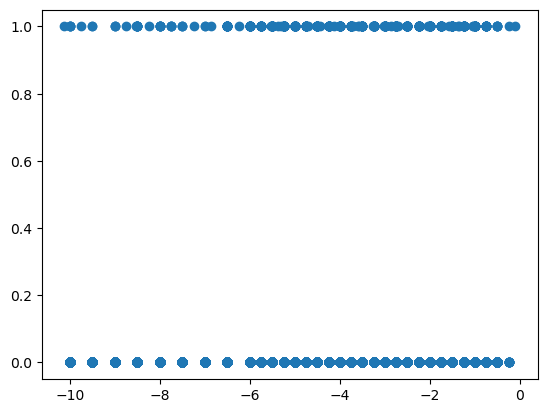

In [25]:
plt.scatter(df_final['POWER'], df_final['target'])

In [26]:
df_encoded = df_final

In [27]:
#df_encoded = pd.get_dummies(df_final,columns=['MOLD_POS','EQUIP_ID','MOLD_IN_TOP','MOLD_IN_BOT',"MOLD_OUT_TOP",'MOLD_OUT_BOT'])
#df_encoded = pd.get_dummies(df_final,columns=['EQUIP_ID','MOLD_POS','MOLD_IN_TOP'])
df_encoded

,IN_RADIUS,OUT_RADIUS,POWER,target
1,6.3564,7.4551,-6.50,0
3,6.3600,7.6877,-7.50,0
4,7.3411,7.5236,-0.75,0
5,6.4829,7.1508,-4.00,0
6,6.4800,8.2939,-8.50,0
...,...,...,...,...
174123,7.1685,6.2684,-5.50,1
174238,7.3764,7.7534,-2.25,1
174257,6.5082,6.8625,-2.25,1
174862,6.5094,7.2148,-4.25,1


In [28]:
df_encoded_normal = df_encoded.loc[df_encoded['target'] == 0]
df_encoded_anomaly = df_encoded.loc[df_encoded['target'] == 1]


In [29]:
df_encoded_anomaly

,IN_RADIUS,OUT_RADIUS,POWER,target
121,6.4741,7.1521,-3.50,1
2297,7.3455,7.9546,-3.50,1
2893,7.2074,6.3643,-5.25,1
3175,8.5852,7.3512,-6.50,1
4051,8.0007,7.3452,-3.50,1
...,...,...,...,...
174123,7.1685,6.2684,-5.50,1
174238,7.3764,7.7534,-2.25,1
174257,6.5082,6.8625,-2.25,1
174862,6.5094,7.2148,-4.25,1


In [30]:
df_x = df_encoded_normal.drop('target',axis=1)

#df_y = df_encoded['POWER_MEAN']
#df_x = df_encoded.drop('POWER_MEAN',axis=1)
#df_y = df_encoded['REAL_POWER']
#df_x = df_encoded.drop('REAL_POWER',axis=1)

In [31]:
df_x

,IN_RADIUS,OUT_RADIUS,POWER
1,6.3564,7.4551,-6.50
3,6.3600,7.6877,-7.50
4,7.3411,7.5236,-0.75
5,6.4829,7.1508,-4.00
6,6.4800,8.2939,-8.50
...,...,...,...
175095,6.3326,6.9997,-4.00
175096,6.3279,7.0979,-4.75
175097,6.3304,7.1881,-5.25
175098,6.4933,6.8071,-5.25


In [32]:
train_x, val_x = train_test_split(df_x, test_size = 0.2,random_state=SEED)
train_x.reset_index(drop=True, inplace=True)
val_x.reset_index(drop=True, inplace=True)

val_x, test_x = train_test_split(val_x, test_size = 0.5, random_state=SEED)
val_x.reset_index(drop=True, inplace=True)
test_x.reset_index(drop=True, inplace=True)

scaler = MinMaxScaler()
train_x = scaler.fit_transform(train_x)
val_x = scaler.transform(val_x)
test_x = scaler.transform(test_x)

In [33]:
print(train_x.shape)
print(val_x.shape)
print(test_x.shape)

(22456, 3)
(2807, 3)
(2807, 3)


In [34]:
class MyDataset(Dataset):
    def __init__(self, origin_x):
        self.data = origin_x
        
    def __getitem__(self, index):
        self.x = self.data[index]
        return torch.Tensor(self.x)

    def __len__(self):
        return len(self.data)

#Pytorch를 사용하기 위해 custom dataset 구성해줌

In [35]:
class AutoEncoder(nn.Module):
    def __init__(self,in_features):
        super(AutoEncoder, self).__init__()
        self.feature_num = in_features
        self.Encoder = nn.Sequential(
            nn.Linear(in_features,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),

        )
        self.Decoder = nn.Sequential(
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,in_features),
        )

        self.init_weight()

    def forward(self, x):
        encoded = self.Encoder(x)
        decoded = self.Decoder(encoded)
        return decoded, encoded

    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant(m.weight, 1)
                nn.init.constant(m.bias, 0)

In [36]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, val_loader, scheduler, device):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.scheduler = scheduler
        self.device = device
        # Loss Function
        self.criterion = nn.MSELoss().to(self.device)
        
    def fit(self):
        self.model.to(self.device)
        best_loss = 1000000000
        for epoch in range(EPOCHS):
            self.model.train()
            train_loss = []
            i = 1
            for x in iter(self.train_loader):
                x = x.float().to(self.device)
                self.optimizer.zero_grad()
                _x,_ = self.model(x)
                loss = self.criterion(x,_x)
                loss.backward()
                self.optimizer.step()
                train_loss.append(loss.item())
                i=i+1
                
            val_loss, mse_list = self.validation(self.model)
            
            mean_train_loss = np.mean(train_loss)
            print(f'Epoch : [{epoch+1}] Train loss : [{mean_train_loss}] val loss : [{val_loss}]\n')
            self.scheduler.step(val_loss)
            
            if best_loss > val_loss:
                best_loss = val_loss
                torch.save(self.model, './' + MODEL_NAME+'.pth')
                print("SAVE MODEL ~_~")
                
        print(best_loss)
           
    def validation(self, eval_model):
        eval_model.eval()
        val_loss = []
        mse_list = []
        with torch.no_grad():
            for x in iter(self.val_loader):
                pred_tmp = []
                x = x.float().to(self.device)
                _x,_ = eval_model(x)
                error = x-_x
                mse = np.mean(np.power(error.numpy(),2),axis=1)
                loss = self.criterion(x,_x)
                val_loss.append(loss.item())
                mse_list += mse.tolist()
        return np.mean(val_loss), mse_list

In [37]:
train_x_tensor = torch.tensor(train_x)
val_x_tensor = torch.tensor(val_x)

In [38]:
train_dataset = MyDataset(train_x_tensor)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
val_dataset = MyDataset(val_x_tensor)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False)

In [39]:
it = iter(train_loader)
in_features = next(it)[0].shape[0]
in_features

3

In [40]:
#Train model
gc.collect()

seed_everything(SEED)
model = AutoEncoder(in_features)
#Using AdamW Optimizer
optimizer = torch.optim.AdamW(params = model.parameters(), lr = LR)#Opimizer : AdamW
#Using Learning Rate Scheduler (ReduceLROnPlateau)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, threshold = 1e-8, threshold_mode='abs', min_lr=1e-8, verbose=True)
trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
#trainer 객체 생성
trainer.fit()

Epoch : [1] Train loss : [0.0032855542874015756] val loss : [1.8306026065188647e-05]

SAVE MODEL ~_~
Epoch : [2] Train loss : [1.7236136089913246e-05] val loss : [1.7387654534931325e-05]

SAVE MODEL ~_~
Epoch : [3] Train loss : [1.5114304652670761e-05] val loss : [1.7229930067101535e-05]

SAVE MODEL ~_~
Epoch : [4] Train loss : [1.3845556540389256e-05] val loss : [1.2687011183681369e-05]

SAVE MODEL ~_~
Epoch : [5] Train loss : [1.7234274069231886e-05] val loss : [1.6140372622430732e-05]

Epoch : [6] Train loss : [2.9215474832681062e-05] val loss : [4.1931644959318376e-05]

Epoch : [7] Train loss : [2.5846243827675833e-05] val loss : [1.629360363866991e-05]

Epoch : [8] Train loss : [1.827828848626789e-05] val loss : [0.00011700023424054962]

Epoch : [9] Train loss : [2.5066316744379528e-05] val loss : [5.923732650423765e-06]

SAVE MODEL ~_~
Epoch : [10] Train loss : [1.9252101666282856e-05] val loss : [1.0014517199992538e-05]

Epoch : [11] Train loss : [2.4164418099439836e-05] val los

Epoch : [93] Train loss : [1.4398587082618656e-06] val loss : [6.530611432641432e-07]

Epoch : [94] Train loss : [1.6049183030935231e-06] val loss : [5.206216771630973e-07]

Epoch : [95] Train loss : [1.2895958784463768e-06] val loss : [9.066931344715489e-07]

Epoch : [96] Train loss : [1.295914027388046e-06] val loss : [1.8146018176552885e-06]

Epoch 00096: reducing learning rate of group 0 to 2.5000e-04.
Epoch : [97] Train loss : [1.5100003830157864e-07] val loss : [1.7846074533296855e-07]

SAVE MODEL ~_~
Epoch : [98] Train loss : [1.7491868141835464e-07] val loss : [1.469191566385384e-07]

SAVE MODEL ~_~
Epoch : [99] Train loss : [3.579955846195476e-07] val loss : [6.307867811921658e-07]

Epoch : [100] Train loss : [5.020355833893936e-07] val loss : [1.0224587812372605e-06]

Epoch : [101] Train loss : [2.737425941257776e-07] val loss : [1.0720389909124606e-06]

Epoch : [102] Train loss : [4.5434340941613125e-07] val loss : [7.351426673871877e-07]

Epoch : [103] Train loss : [3.48629

Epoch : [183] Train loss : [5.395327666496656e-08] val loss : [1.1406548293780748e-07]

Epoch : [184] Train loss : [6.054183830298597e-08] val loss : [1.2426324054585922e-07]

Epoch : [185] Train loss : [6.439537350965144e-08] val loss : [1.1497398596818895e-07]

Epoch : [186] Train loss : [5.6181393526603555e-08] val loss : [1.0136037633466023e-07]

Epoch : [187] Train loss : [5.772477153699231e-08] val loss : [1.1167709898255138e-07]

Epoch : [188] Train loss : [6.27653136770488e-08] val loss : [1.0083814498558623e-07]

Epoch 00188: reducing learning rate of group 0 to 3.1250e-05.
Epoch : [189] Train loss : [3.251054390178907e-08] val loss : [9.097870274315573e-08]

Epoch : [190] Train loss : [3.3450808423935184e-08] val loss : [9.739937544373976e-08]

Epoch : [191] Train loss : [3.562425806009325e-08] val loss : [9.580076885320275e-08]

Epoch : [192] Train loss : [3.629912278323562e-08] val loss : [9.378876013195607e-08]

Epoch : [193] Train loss : [3.780276170474506e-08] val loss :

Epoch : [274] Train loss : [2.0276676071644362e-08] val loss : [8.075485910782634e-08]

Epoch : [275] Train loss : [2.0380668168629284e-08] val loss : [8.029158242313499e-08]

Epoch : [276] Train loss : [2.0381945601995715e-08] val loss : [7.896405906421772e-08]

SAVE MODEL ~_~
Epoch : [277] Train loss : [2.0453148639130966e-08] val loss : [7.953113194781768e-08]

Epoch : [278] Train loss : [2.029953853918236e-08] val loss : [8.055075919913532e-08]

Epoch : [279] Train loss : [2.0075907862369383e-08] val loss : [8.099581909716168e-08]

Epoch : [280] Train loss : [2.0103479525270894e-08] val loss : [7.912904895970095e-08]

Epoch : [281] Train loss : [2.0191082685830687e-08] val loss : [8.001220796017737e-08]

Epoch : [282] Train loss : [2.0354518813709832e-08] val loss : [8.164191118103564e-08]

Epoch : [283] Train loss : [2.0457869372590062e-08] val loss : [7.902618898663666e-08]

Epoch : [284] Train loss : [2.0223746056098156e-08] val loss : [7.856814370311614e-08]

SAVE MODEL ~_~
Epo

Epoch : [364] Train loss : [1.7891414446202442e-08] val loss : [7.755767101526943e-08]

Epoch : [365] Train loss : [1.7891794949681753e-08] val loss : [7.75998215104848e-08]

Epoch : [366] Train loss : [1.7891951286480277e-08] val loss : [7.77845131184517e-08]

Epoch : [367] Train loss : [1.7867804493336617e-08] val loss : [7.768908637618598e-08]

Epoch : [368] Train loss : [1.788725029727806e-08] val loss : [7.770803067433638e-08]

Epoch : [369] Train loss : [1.7912416799904767e-08] val loss : [7.758530901574351e-08]

Epoch : [370] Train loss : [1.7879298047150277e-08] val loss : [7.749762042703007e-08]

SAVE MODEL ~_~
Epoch : [371] Train loss : [1.785622970852129e-08] val loss : [7.764153398991493e-08]

Epoch : [372] Train loss : [1.789787115949246e-08] val loss : [7.755976273852867e-08]

Epoch : [373] Train loss : [1.785982230735763e-08] val loss : [7.741712087051443e-08]

SAVE MODEL ~_~
Epoch : [374] Train loss : [1.7839768829327863e-08] val loss : [7.76431706201402e-08]

Epoch : [

Epoch : [455] Train loss : [1.7664705051671857e-08] val loss : [7.748101877263541e-08]

Epoch : [456] Train loss : [1.769946967210401e-08] val loss : [7.748042423054309e-08]

Epoch : [457] Train loss : [1.7665104286289996e-08] val loss : [7.74868719315021e-08]

Epoch : [458] Train loss : [1.7671204394679292e-08] val loss : [7.747678668825551e-08]

Epoch : [459] Train loss : [1.766102114537377e-08] val loss : [7.749187743508947e-08]

Epoch : [460] Train loss : [1.766386254137481e-08] val loss : [7.748353618315788e-08]

Epoch : [461] Train loss : [1.7666552988480178e-08] val loss : [7.747694148867042e-08]

Epoch : [462] Train loss : [1.7661161276711767e-08] val loss : [7.749578081523384e-08]

Epoch : [463] Train loss : [1.7658187371006342e-08] val loss : [7.751766458780568e-08]

Epoch : [464] Train loss : [1.7665353861579206e-08] val loss : [7.750410644077635e-08]

Epoch : [465] Train loss : [1.7664939999219185e-08] val loss : [7.748031132590795e-08]

Epoch : [466] Train loss : [1.766428

Epoch : [549] Train loss : [1.7657837586544107e-08] val loss : [7.746476469122127e-08]

Epoch : [550] Train loss : [1.7658687609666587e-08] val loss : [7.748493788009822e-08]

Epoch : [551] Train loss : [1.7661719962762655e-08] val loss : [7.746256152932593e-08]

Epoch : [552] Train loss : [1.765941972330822e-08] val loss : [7.747990624842126e-08]

Epoch : [553] Train loss : [1.7664485730434522e-08] val loss : [7.74663499837246e-08]

Epoch : [554] Train loss : [1.766649027542922e-08] val loss : [7.747295630779825e-08]

Epoch : [555] Train loss : [1.766512373512001e-08] val loss : [7.748751504080528e-08]

Epoch : [556] Train loss : [1.7657311817815142e-08] val loss : [7.746468944585577e-08]

Epoch : [557] Train loss : [1.766843970623277e-08] val loss : [7.752683495429205e-08]

Epoch : [558] Train loss : [1.7659064442767557e-08] val loss : [7.748115177987701e-08]

Epoch : [559] Train loss : [1.7666745207623598e-08] val loss : [7.745977444815401e-08]

Epoch : [560] Train loss : [1.7657493

Epoch : [643] Train loss : [1.7662304595453125e-08] val loss : [7.74575644306315e-08]

Epoch : [644] Train loss : [1.765404080535773e-08] val loss : [7.750840342273851e-08]

Epoch : [645] Train loss : [1.766275771700733e-08] val loss : [7.74705210310705e-08]

Epoch : [646] Train loss : [1.766758707424433e-08] val loss : [7.745538271370317e-08]

Epoch : [647] Train loss : [1.7652864455425418e-08] val loss : [7.746972545786722e-08]

Epoch : [648] Train loss : [1.7670131621596515e-08] val loss : [7.748313429251591e-08]

Epoch : [649] Train loss : [1.7660397289231333e-08] val loss : [7.746691937674219e-08]

Epoch : [650] Train loss : [1.766523117782305e-08] val loss : [7.745654418361331e-08]

Epoch : [651] Train loss : [1.7655276558864216e-08] val loss : [7.74527195409905e-08]

Epoch : [652] Train loss : [1.7659456186068855e-08] val loss : [7.748400885556415e-08]

Epoch : [653] Train loss : [1.7658051164037878e-08] val loss : [7.74774948162562e-08]

Epoch : [654] Train loss : [1.7656128227

Epoch : [737] Train loss : [1.7655682820150303e-08] val loss : [7.745556319054875e-08]

Epoch : [738] Train loss : [1.765266939999429e-08] val loss : [7.746418491509517e-08]

Epoch : [739] Train loss : [1.765886741518812e-08] val loss : [7.746361392739361e-08]

Epoch : [740] Train loss : [1.7653230414824953e-08] val loss : [7.747865110596663e-08]

Epoch : [741] Train loss : [1.764811400879233e-08] val loss : [7.747178546155001e-08]

Epoch : [742] Train loss : [1.764752399231095e-08] val loss : [7.745321914387482e-08]

Epoch : [743] Train loss : [1.7656999510813102e-08] val loss : [7.745043144198731e-08]

Epoch : [744] Train loss : [1.765352097363337e-08] val loss : [7.746542560194136e-08]

Epoch : [745] Train loss : [1.7652958836718322e-08] val loss : [7.746411275059857e-08]

Epoch : [746] Train loss : [1.7649289026773316e-08] val loss : [7.748792065574085e-08]

Epoch : [747] Train loss : [1.7653772427761545e-08] val loss : [7.747164570465709e-08]

Epoch : [748] Train loss : [1.7651932

Epoch : [831] Train loss : [1.765171505354753e-08] val loss : [7.745904348740754e-08]

Epoch : [832] Train loss : [1.7646295795595994e-08] val loss : [7.745292383716644e-08]

Epoch : [833] Train loss : [1.765054895214406e-08] val loss : [7.747850631774482e-08]

Epoch : [834] Train loss : [1.764953322238355e-08] val loss : [7.744721167914713e-08]

Epoch : [835] Train loss : [1.7655497369255395e-08] val loss : [7.74525633149483e-08]

Epoch : [836] Train loss : [1.764992815876218e-08] val loss : [7.745453259070087e-08]

Epoch : [837] Train loss : [1.7653237505860532e-08] val loss : [7.747797657482862e-08]

Epoch : [838] Train loss : [1.7650155518520297e-08] val loss : [7.744225499761725e-08]

Epoch : [839] Train loss : [1.7651447530601665e-08] val loss : [7.745916181951933e-08]

Epoch : [840] Train loss : [1.7652999978547107e-08] val loss : [7.746244944978836e-08]

Epoch : [841] Train loss : [1.765279436777337e-08] val loss : [7.744804637509585e-08]

Epoch : [842] Train loss : [1.76542456

Epoch : [925] Train loss : [1.7648702050911288e-08] val loss : [7.744904212655693e-08]

Epoch : [926] Train loss : [1.7645528104841724e-08] val loss : [7.745386956551056e-08]

Epoch : [927] Train loss : [1.7659601038543284e-08] val loss : [7.746947428757055e-08]

Epoch : [928] Train loss : [1.7646751182827558e-08] val loss : [7.745245269131683e-08]

Epoch : [929] Train loss : [1.7646699798795992e-08] val loss : [7.746279493605422e-08]

Epoch : [930] Train loss : [1.7649720789660867e-08] val loss : [7.74464777889258e-08]

Epoch : [931] Train loss : [1.765012346106769e-08] val loss : [7.744963288127481e-08]

Epoch : [932] Train loss : [1.765097577248318e-08] val loss : [7.746069666247912e-08]

Epoch : [933] Train loss : [1.765257455436879e-08] val loss : [7.747474402928424e-08]

Epoch : [934] Train loss : [1.765495428136355e-08] val loss : [7.745260422666676e-08]

Epoch : [935] Train loss : [1.765292876485689e-08] val loss : [7.74966567988629e-08]

Epoch : [936] Train loss : [1.764866237

Epoch : [1019] Train loss : [1.7652234803982054e-08] val loss : [7.744701781149792e-08]

Epoch : [1020] Train loss : [1.764659098681789e-08] val loss : [7.742919122785433e-08]

Epoch : [1021] Train loss : [1.764584216922243e-08] val loss : [7.742515243077977e-08]

Epoch : [1022] Train loss : [1.764202935243016e-08] val loss : [7.742239524740926e-08]

Epoch : [1023] Train loss : [1.7647187775343416e-08] val loss : [7.742948782898183e-08]

Epoch : [1024] Train loss : [1.7642797718174724e-08] val loss : [7.743861515666337e-08]

Epoch : [1025] Train loss : [1.764023804648518e-08] val loss : [7.743715924299091e-08]

Epoch : [1026] Train loss : [1.764012620843765e-08] val loss : [7.744550720924857e-08]

Epoch : [1027] Train loss : [1.764399823427784e-08] val loss : [7.743268476412268e-08]

Epoch : [1028] Train loss : [1.7644803639719453e-08] val loss : [7.743424670157074e-08]

Epoch : [1029] Train loss : [1.7642964434925924e-08] val loss : [7.741848897563858e-08]

Epoch : [1030] Train loss :

Epoch : [1112] Train loss : [1.76484930123635e-08] val loss : [7.745410768059377e-08]

Epoch : [1113] Train loss : [1.7641136183067695e-08] val loss : [7.742689059847036e-08]

Epoch : [1114] Train loss : [1.7643001366921846e-08] val loss : [7.743964338971762e-08]

Epoch : [1115] Train loss : [1.7639727004184584e-08] val loss : [7.743739583404069e-08]

Epoch : [1116] Train loss : [1.7646433943398784e-08] val loss : [7.744254905027827e-08]

Epoch : [1117] Train loss : [1.7639096824831755e-08] val loss : [7.742150358187998e-08]

Epoch : [1118] Train loss : [1.7648278089317377e-08] val loss : [7.743765590883069e-08]

Epoch : [1119] Train loss : [1.7644336412006775e-08] val loss : [7.742451305838637e-08]

Epoch : [1120] Train loss : [1.7638395100303318e-08] val loss : [7.741852960223157e-08]

Epoch : [1121] Train loss : [1.7641343531925626e-08] val loss : [7.740973827850196e-08]

SAVE MODEL ~_~
Epoch : [1122] Train loss : [1.764036106647127e-08] val loss : [7.742088468553167e-08]

Epoch : [

Epoch : [1205] Train loss : [1.76358977839262e-08] val loss : [7.742126099310263e-08]

Epoch : [1206] Train loss : [1.764142363562391e-08] val loss : [7.742447289606845e-08]

Epoch : [1207] Train loss : [1.764021658122446e-08] val loss : [7.741824540027667e-08]

Epoch : [1208] Train loss : [1.7646374044494334e-08] val loss : [7.742549273684593e-08]

Epoch : [1209] Train loss : [1.7637287311861775e-08] val loss : [7.742910496604855e-08]

Epoch : [1210] Train loss : [1.7639430983932905e-08] val loss : [7.741486984791379e-08]

Epoch : [1211] Train loss : [1.7652303659318176e-08] val loss : [7.7407418628979e-08]

SAVE MODEL ~_~
Epoch : [1212] Train loss : [1.7641083849811257e-08] val loss : [7.741674437874738e-08]

Epoch : [1213] Train loss : [1.763670984279839e-08] val loss : [7.742386495055632e-08]

Epoch : [1214] Train loss : [1.763617204095987e-08] val loss : [7.742735659944554e-08]

Epoch : [1215] Train loss : [1.7637682832768082e-08] val loss : [7.741347452213967e-08]

Epoch : [1216]

Epoch : [1297] Train loss : [1.7633350330383374e-08] val loss : [7.74352453471814e-08]

Epoch : [1298] Train loss : [1.7642935633178612e-08] val loss : [7.74278435104621e-08]

Epoch : [1299] Train loss : [1.763846319050283e-08] val loss : [7.74140277210405e-08]

Epoch : [1300] Train loss : [1.7639377464540755e-08] val loss : [7.74197962203551e-08]

Epoch : [1301] Train loss : [1.7645858232979277e-08] val loss : [7.741168258432941e-08]

Epoch : [1302] Train loss : [1.764585951685257e-08] val loss : [7.740588323090769e-08]

Epoch : [1303] Train loss : [1.7629109991375945e-08] val loss : [7.740893770929508e-08]

Epoch : [1304] Train loss : [1.763396155022671e-08] val loss : [7.741335082058563e-08]

Epoch : [1305] Train loss : [1.7634031194422153e-08] val loss : [7.741680979106941e-08]

Epoch : [1306] Train loss : [1.7638781427867116e-08] val loss : [7.74067091031066e-08]

Epoch : [1307] Train loss : [1.7631519872470876e-08] val loss : [7.740335958042718e-08]

Epoch : [1308] Train loss : [

Epoch : [1390] Train loss : [1.76289369623268e-08] val loss : [7.742087727226975e-08]

Epoch : [1391] Train loss : [1.7630884472223105e-08] val loss : [7.740384602464542e-08]

Epoch : [1392] Train loss : [1.7632328495028836e-08] val loss : [7.740360675392098e-08]

Epoch : [1393] Train loss : [1.7632435854544225e-08] val loss : [7.74039195844905e-08]

Epoch : [1394] Train loss : [1.763006703588606e-08] val loss : [7.741349760216242e-08]

Epoch : [1395] Train loss : [1.763271648887608e-08] val loss : [7.740492831546804e-08]

Epoch : [1396] Train loss : [1.763107172161605e-08] val loss : [7.740249962690465e-08]

Epoch : [1397] Train loss : [1.7633200972807368e-08] val loss : [7.740458167103771e-08]

Epoch : [1398] Train loss : [1.7623790209723715e-08] val loss : [7.739448393525886e-08]

SAVE MODEL ~_~
Epoch : [1399] Train loss : [1.7631245915924916e-08] val loss : [7.739608561364474e-08]

Epoch : [1400] Train loss : [1.763935835731783e-08] val loss : [7.739319273831152e-08]

SAVE MODEL ~_

Epoch : [1481] Train loss : [1.762703255470438e-08] val loss : [7.739688656890645e-08]

Epoch : [1482] Train loss : [1.762795224479611e-08] val loss : [7.739798546513299e-08]

Epoch : [1483] Train loss : [1.7628753187204422e-08] val loss : [7.73972642793956e-08]

Epoch : [1484] Train loss : [1.7632834824100572e-08] val loss : [7.739824387963491e-08]

Epoch : [1485] Train loss : [1.7626781259992845e-08] val loss : [7.742454691009568e-08]

Epoch : [1486] Train loss : [1.7628990744882923e-08] val loss : [7.738978195150702e-08]

Epoch : [1487] Train loss : [1.7625255558300604e-08] val loss : [7.739685795795446e-08]

Epoch : [1488] Train loss : [1.7626741102182243e-08] val loss : [7.738963030008832e-08]

Epoch : [1489] Train loss : [1.763518012121315e-08] val loss : [7.742490077097566e-08]

Epoch : [1490] Train loss : [1.763294140266421e-08] val loss : [7.740271372836847e-08]

Epoch : [1491] Train loss : [1.7626026955808045e-08] val loss : [7.73867885379092e-08]

Epoch : [1492] Train loss :

Epoch : [1574] Train loss : [1.7629181984120095e-08] val loss : [7.73844753806677e-08]

Epoch : [1575] Train loss : [1.7626198372977835e-08] val loss : [7.740384266369754e-08]

Epoch : [1576] Train loss : [1.7635588824040983e-08] val loss : [7.738384620214024e-08]

Epoch : [1577] Train loss : [1.762403332326188e-08] val loss : [7.739625838705648e-08]

Epoch : [1578] Train loss : [1.7625176978233176e-08] val loss : [7.741356606759776e-08]

Epoch : [1579] Train loss : [1.762504195202327e-08] val loss : [7.737640893416704e-08]

Epoch : [1580] Train loss : [1.7620067711314165e-08] val loss : [7.7383115879772e-08]

Epoch : [1581] Train loss : [1.76247234284049e-08] val loss : [7.739887097144772e-08]

Epoch : [1582] Train loss : [1.762011809203307e-08] val loss : [7.73754303659305e-08]

Epoch : [1583] Train loss : [1.7625594599220033e-08] val loss : [7.738998384556404e-08]

Epoch : [1584] Train loss : [1.7622472034809764e-08] val loss : [7.739977935844972e-08]

Epoch : [1585] Train loss : [1

Epoch : [1666] Train loss : [1.7619518645930944e-08] val loss : [7.739497660177251e-08]

Epoch : [1667] Train loss : [1.762945313189669e-08] val loss : [7.738415751119958e-08]

Epoch : [1668] Train loss : [1.7618926432409923e-08] val loss : [7.739834699412156e-08]

Epoch : [1669] Train loss : [1.762383742614885e-08] val loss : [7.738066890028428e-08]

Epoch : [1670] Train loss : [1.7619623175800984e-08] val loss : [7.737688174535119e-08]

Epoch : [1671] Train loss : [1.7628253525796892e-08] val loss : [7.738927868488671e-08]

Epoch : [1672] Train loss : [1.7620763910031708e-08] val loss : [7.737796730123879e-08]

Epoch : [1673] Train loss : [1.7623858880022664e-08] val loss : [7.738329721199397e-08]

Epoch : [1674] Train loss : [1.761624538614174e-08] val loss : [7.737707989745198e-08]

Epoch : [1675] Train loss : [1.762123918891728e-08] val loss : [7.738704212294097e-08]

Epoch : [1676] Train loss : [1.7622222411284367e-08] val loss : [7.738074986582158e-08]

Epoch : [1677] Train loss

Epoch : [1759] Train loss : [1.762255107841903e-08] val loss : [7.7383807523484e-08]

Epoch : [1760] Train loss : [1.7623744311332582e-08] val loss : [7.738780741228801e-08]

Epoch : [1761] Train loss : [1.7620888311312372e-08] val loss : [7.738100860329747e-08]

Epoch : [1762] Train loss : [1.761813316920235e-08] val loss : [7.736978188172489e-08]

SAVE MODEL ~_~
Epoch : [1763] Train loss : [1.7627978687714875e-08] val loss : [7.739687679137414e-08]

Epoch : [1764] Train loss : [1.7621230696501898e-08] val loss : [7.73759126468124e-08]

Epoch : [1765] Train loss : [1.7621837501073667e-08] val loss : [7.738309857290898e-08]

Epoch : [1766] Train loss : [1.7619669755824772e-08] val loss : [7.739748311192346e-08]

Epoch : [1767] Train loss : [1.7616608564764716e-08] val loss : [7.737292549588175e-08]

Epoch : [1768] Train loss : [1.761706213546898e-08] val loss : [7.737800191748806e-08]

Epoch : [1769] Train loss : [1.7619464150744488e-08] val loss : [7.737467061003594e-08]

Epoch : [177

Epoch : [1851] Train loss : [1.7613627675724837e-08] val loss : [7.737861553018406e-08]

Epoch : [1852] Train loss : [1.7617857169656246e-08] val loss : [7.7377283741969e-08]

Epoch : [1853] Train loss : [1.7611280034491795e-08] val loss : [7.738507782805261e-08]

Epoch : [1854] Train loss : [1.7615806854689372e-08] val loss : [7.736725474413478e-08]

Epoch : [1855] Train loss : [1.761478159124448e-08] val loss : [7.73817637391503e-08]

Epoch : [1856] Train loss : [1.7613751957443025e-08] val loss : [7.736452749389096e-08]

Epoch : [1857] Train loss : [1.7613522970623016e-08] val loss : [7.736584323686008e-08]

Epoch : [1858] Train loss : [1.761286483389335e-08] val loss : [7.736914391224965e-08]

Epoch : [1859] Train loss : [1.761124184503387e-08] val loss : [7.737017779482516e-08]

Epoch : [1860] Train loss : [1.761361884613061e-08] val loss : [7.738511000433444e-08]

Epoch : [1861] Train loss : [1.761614237579062e-08] val loss : [7.736918559607776e-08]

Epoch : [1862] Train loss : [

Epoch : [1943] Train loss : [1.7612595875881427e-08] val loss : [7.735615876646275e-08]

Epoch : [1944] Train loss : [1.761296689264733e-08] val loss : [7.736150730373238e-08]

Epoch : [1945] Train loss : [1.761487488793489e-08] val loss : [7.737605552242273e-08]

Epoch : [1946] Train loss : [1.762711553391193e-08] val loss : [7.738734471927279e-08]

Epoch : [1947] Train loss : [1.7615429689154103e-08] val loss : [7.736379660127181e-08]

Epoch : [1948] Train loss : [1.7619701690710025e-08] val loss : [7.735417244626351e-08]

Epoch : [1949] Train loss : [1.761357887841803e-08] val loss : [7.736115112652345e-08]

Epoch : [1950] Train loss : [1.7615253503402454e-08] val loss : [7.736847782132986e-08]

Epoch : [1951] Train loss : [1.7634084683132924e-08] val loss : [7.735198624050164e-08]

Epoch : [1952] Train loss : [1.7622208146658167e-08] val loss : [7.736336085639728e-08]

Epoch : [1953] Train loss : [1.7615259558071723e-08] val loss : [7.737069449262082e-08]

Epoch : [1954] Train loss

In [41]:
pretrained_model = torch.load('./' + MODEL_NAME+'.pth')
pretrained_model = pretrained_model.to(device)
pretrained_model.eval()
summary(pretrained_model)

Layer (type:depth-idx)                   Param #
AutoEncoder                              --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       512
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       8,256
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       2,080
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       528
│    └─ReLU: 2-8                         --
├─Sequential: 1-2                        --
│    └─Linear: 2-9                       544
│    └─ReLU: 2-10                        --
│    └─Linear: 2-11                      2,112
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      8,320
│    └─ReLU: 2-14                        --
│    └─Linear: 2-15                      387
Total params: 22,739
Trainable params: 22,739
Non-trainable params: 0

In [42]:
df_x_anoamly = df_encoded_anomaly.drop('target', axis=1)

In [43]:
anomaly_val =  df_x_anoamly.iloc[:400,:]
anomaly_test = df_x_anoamly.iloc[400:,:]

anomaly_val = scaler.transform(anomaly_val)
anomaly_test = scaler.transform(anomaly_test)
anomaly_val_tensor = torch.tensor(anomaly_val)
anomaly_test_tensor = torch.tensor(anomaly_test)
normal_test_tensor = torch.tensor(test_x)
print(anomaly_val_tensor.shape)
print(anomaly_test_tensor.shape)
print(normal_test_tensor.shape)

torch.Size([400, 3])
torch.Size([123, 3])
torch.Size([2807, 3])


In [44]:
pretrained_model.eval()
val_loss = []
mse_list_normal = []
with torch.no_grad():
    for x in iter(val_loader):
        pred_tmp = []
        x = x.float().to(device)
        _x,_ = pretrained_model(x)
        error = x-_x
        mse = np.mean(np.power(error.numpy(),2),axis=1)
        mse_list_normal += mse.tolist()

In [45]:
mse_list_val_anomaly = []
with torch.no_grad():
    x = anomaly_val_tensor.float().to(device)
    _x,_ = pretrained_model(x)
    error = x-_x
    mse = np.mean(np.power(error.numpy(),2),axis=1)
    mse_list_val_anomaly += mse.tolist()

In [46]:
mse_list_test_normal = []
with torch.no_grad():
    x = normal_test_tensor.float().to(device)
    _x,_ = pretrained_model(x)
    error = x-_x
    mse = np.mean(np.power(error.numpy(),2),axis=1)
    mse_list_test_normal += mse.tolist()

In [47]:
mse_list_test_anomaly = []
with torch.no_grad():
    x = anomaly_test_tensor.float().to(device)
    _x,_ = pretrained_model(x)
    error = x-_x
    mse = np.mean(np.power(error.numpy(),2),axis=1)
    mse_list_test_anomaly += mse.tolist()

In [48]:
mse_list_test_anomaly

[1.3197658244035182e-10,
 1.0614537693243165e-08,
 4.240844564407098e-09,
 3.605517849791795e-05,
 8.006373342084316e-09,
 7.209077779180006e-11,
 0.00013621244579553604,
 4.517607521847822e-05,
 1.108643027691869e-05,
 5.840200174134225e-06,
 1.9986666757176863e-06,
 0.0033716412726789713,
 0.0001170286486740224,
 0.0002501093258615583,
 8.071546631072124e-07,
 0.0007985521224327385,
 1.273599082196597e-06,
 0.0001523442770121619,
 3.845654191536596e-06,
 6.593922630138138e-10,
 1.15690045277006e-05,
 0.00026079118833877146,
 4.480296411202289e-06,
 0.0030630945693701506,
 8.158167474903166e-08,
 6.576732971552701e-07,
 1.98596694644948e-12,
 1.8575515525753872e-07,
 1.5281104159825531e-09,
 7.697309456489165e-11,
 6.780256711635957e-08,
 2.5860379082587315e-06,
 3.142747289075487e-07,
 2.981838065352349e-07,
 5.746259716943314e-07,
 0.00903515238314867,
 4.103824480239382e-08,
 4.416760077674553e-07,
 7.071539798175763e-09,
 1.638177877794078e-07,
 1.9537007744929724e-07,
 2.59260328

In [58]:
val_anomaly_count = 0
test_anomaly_count = 0
false_positive = 0 
thr_list = [(i+1) * 1e-8  for  i  in range(1,1000)]
best_f1 = 0
best_thr = 0
best_fpr = 0
best_recall = 0
best_false_positive = 0
best_val_anomaly_count = 0
best_precision = 0
for thr in thr_list:
    val_anomaly_count = 0
    false_positive = 0 
    for i in range(len(mse_list_normal)):
        if mse_list_normal[i] > thr:
            false_positive = false_positive+1
    print(f"False Positive Count : {false_positive} / Whole Val Normal Data {str(len(mse_list_normal))} ")
    print(f"False Positive Rate : {false_positive/len(mse_list_normal):.5f}")
    print()
    for i in range(len(mse_list_val_anomaly)):
        if mse_list_val_anomaly[i] > thr:
            val_anomaly_count = val_anomaly_count+1
    print(f"Detect Anomaly in Val Data : {str(val_anomaly_count)} / Whole Val Data {str(len(mse_list_val_anomaly))} ")
    print(f"Recall : {val_anomaly_count/len(mse_list_val_anomaly):.5f}")
    print()

    print("Confusion matrix")
    print(f"[{len(mse_list_normal)-false_positive} {false_positive}]\n[{len(mse_list_val_anomaly)-val_anomaly_count} {val_anomaly_count}]")
    
    precision = val_anomaly_count / (val_anomaly_count + false_positive)
    recall = val_anomaly_count / len(mse_list_val_anomaly)
    f1_score = 2 * precision * recall/(precision+recall)
    print(f"F1-score : {f1_score:.5f}")
    print()
    
    '''if best_f1 < f1_score:
        best_f1 = f1_score
        best_thr = thr
        best_fpr = false_positive/len(mse_list_normal)
        best_recall = val_anomaly_count/len(mse_list_val_anomaly)
        best_val_anomaly_count = val_anomaly_count
        best_false_positive = false_positive'''
    if best_f1 < f1_score:
        best_f1 = f1_score
        best_thr = thr
        best_fpr = false_positive/len(mse_list_normal)
        best_recall = val_anomaly_count/len(mse_list_val_anomaly)
        best_val_anomaly_count = val_anomaly_count
        best_false_positive = false_positive
        best_precision = precision
print(f"Best F1 : {best_f1}")
print(f"Best False Positive Rate(Criterion : F1) : {best_fpr}")
print(f"Best Recall(Creiterion : F1) : {best_recall}")
print(f"Best Threshold(Criterion : F1) : {best_thr}")
print(f"Best Precision(Criterion : F1) : {best_precision}")
print("Confusion matrix")
print(f"[{len(mse_list_normal)-best_false_positive} {best_false_positive}]\n[{len(mse_list_val_anomaly)-best_val_anomaly_count} {best_val_anomaly_count}]")


False Positive Count : 405 / Whole Val Normal Data 2807 
False Positive Rate : 0.14428

Detect Anomaly in Val Data : 249 / Whole Val Data 400 
Recall : 0.62250

Confusion matrix
[2402 405]
[151 249]
F1-score : 0.47249

False Positive Count : 290 / Whole Val Normal Data 2807 
False Positive Rate : 0.10331

Detect Anomaly in Val Data : 238 / Whole Val Data 400 
Recall : 0.59500

Confusion matrix
[2517 290]
[162 238]
F1-score : 0.51293

False Positive Count : 231 / Whole Val Normal Data 2807 
False Positive Rate : 0.08229

Detect Anomaly in Val Data : 231 / Whole Val Data 400 
Recall : 0.57750

Confusion matrix
[2576 231]
[169 231]
F1-score : 0.53596

False Positive Count : 194 / Whole Val Normal Data 2807 
False Positive Rate : 0.06911

Detect Anomaly in Val Data : 229 / Whole Val Data 400 
Recall : 0.57250

Confusion matrix
[2613 194]
[171 229]
F1-score : 0.55650

False Positive Count : 172 / Whole Val Normal Data 2807 
False Positive Rate : 0.06128

Detect Anomaly in Val Data : 226 / W

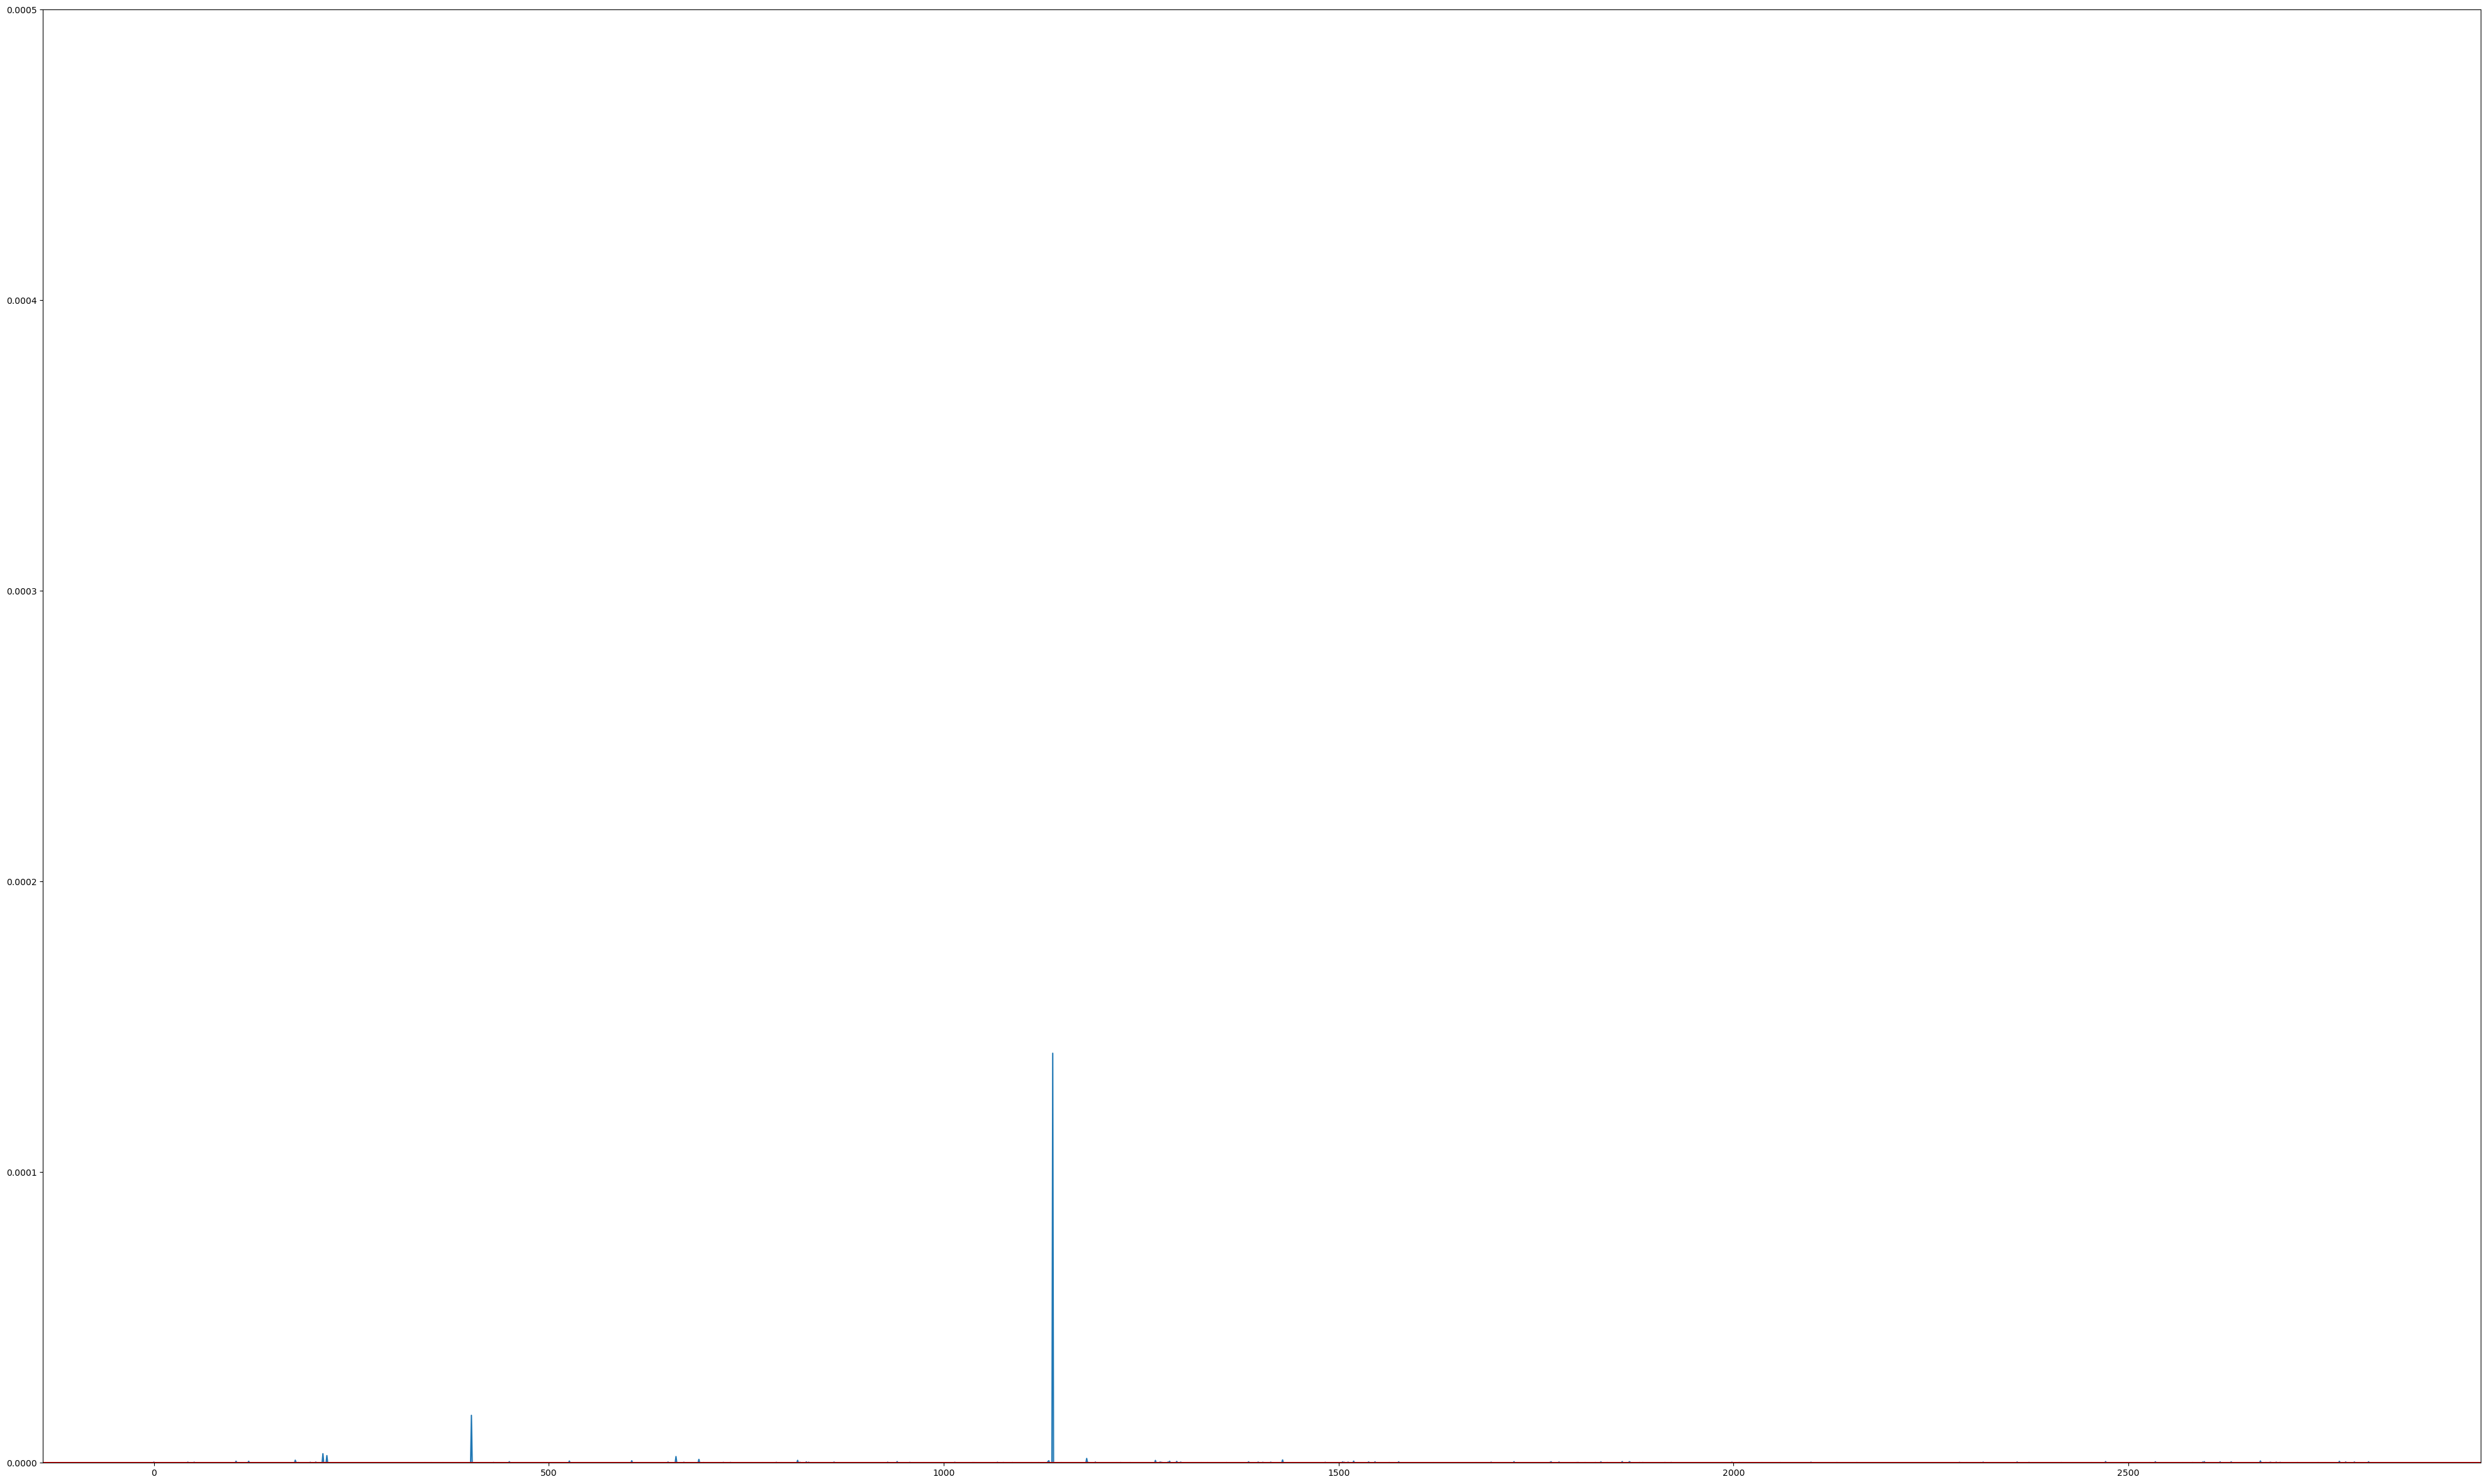

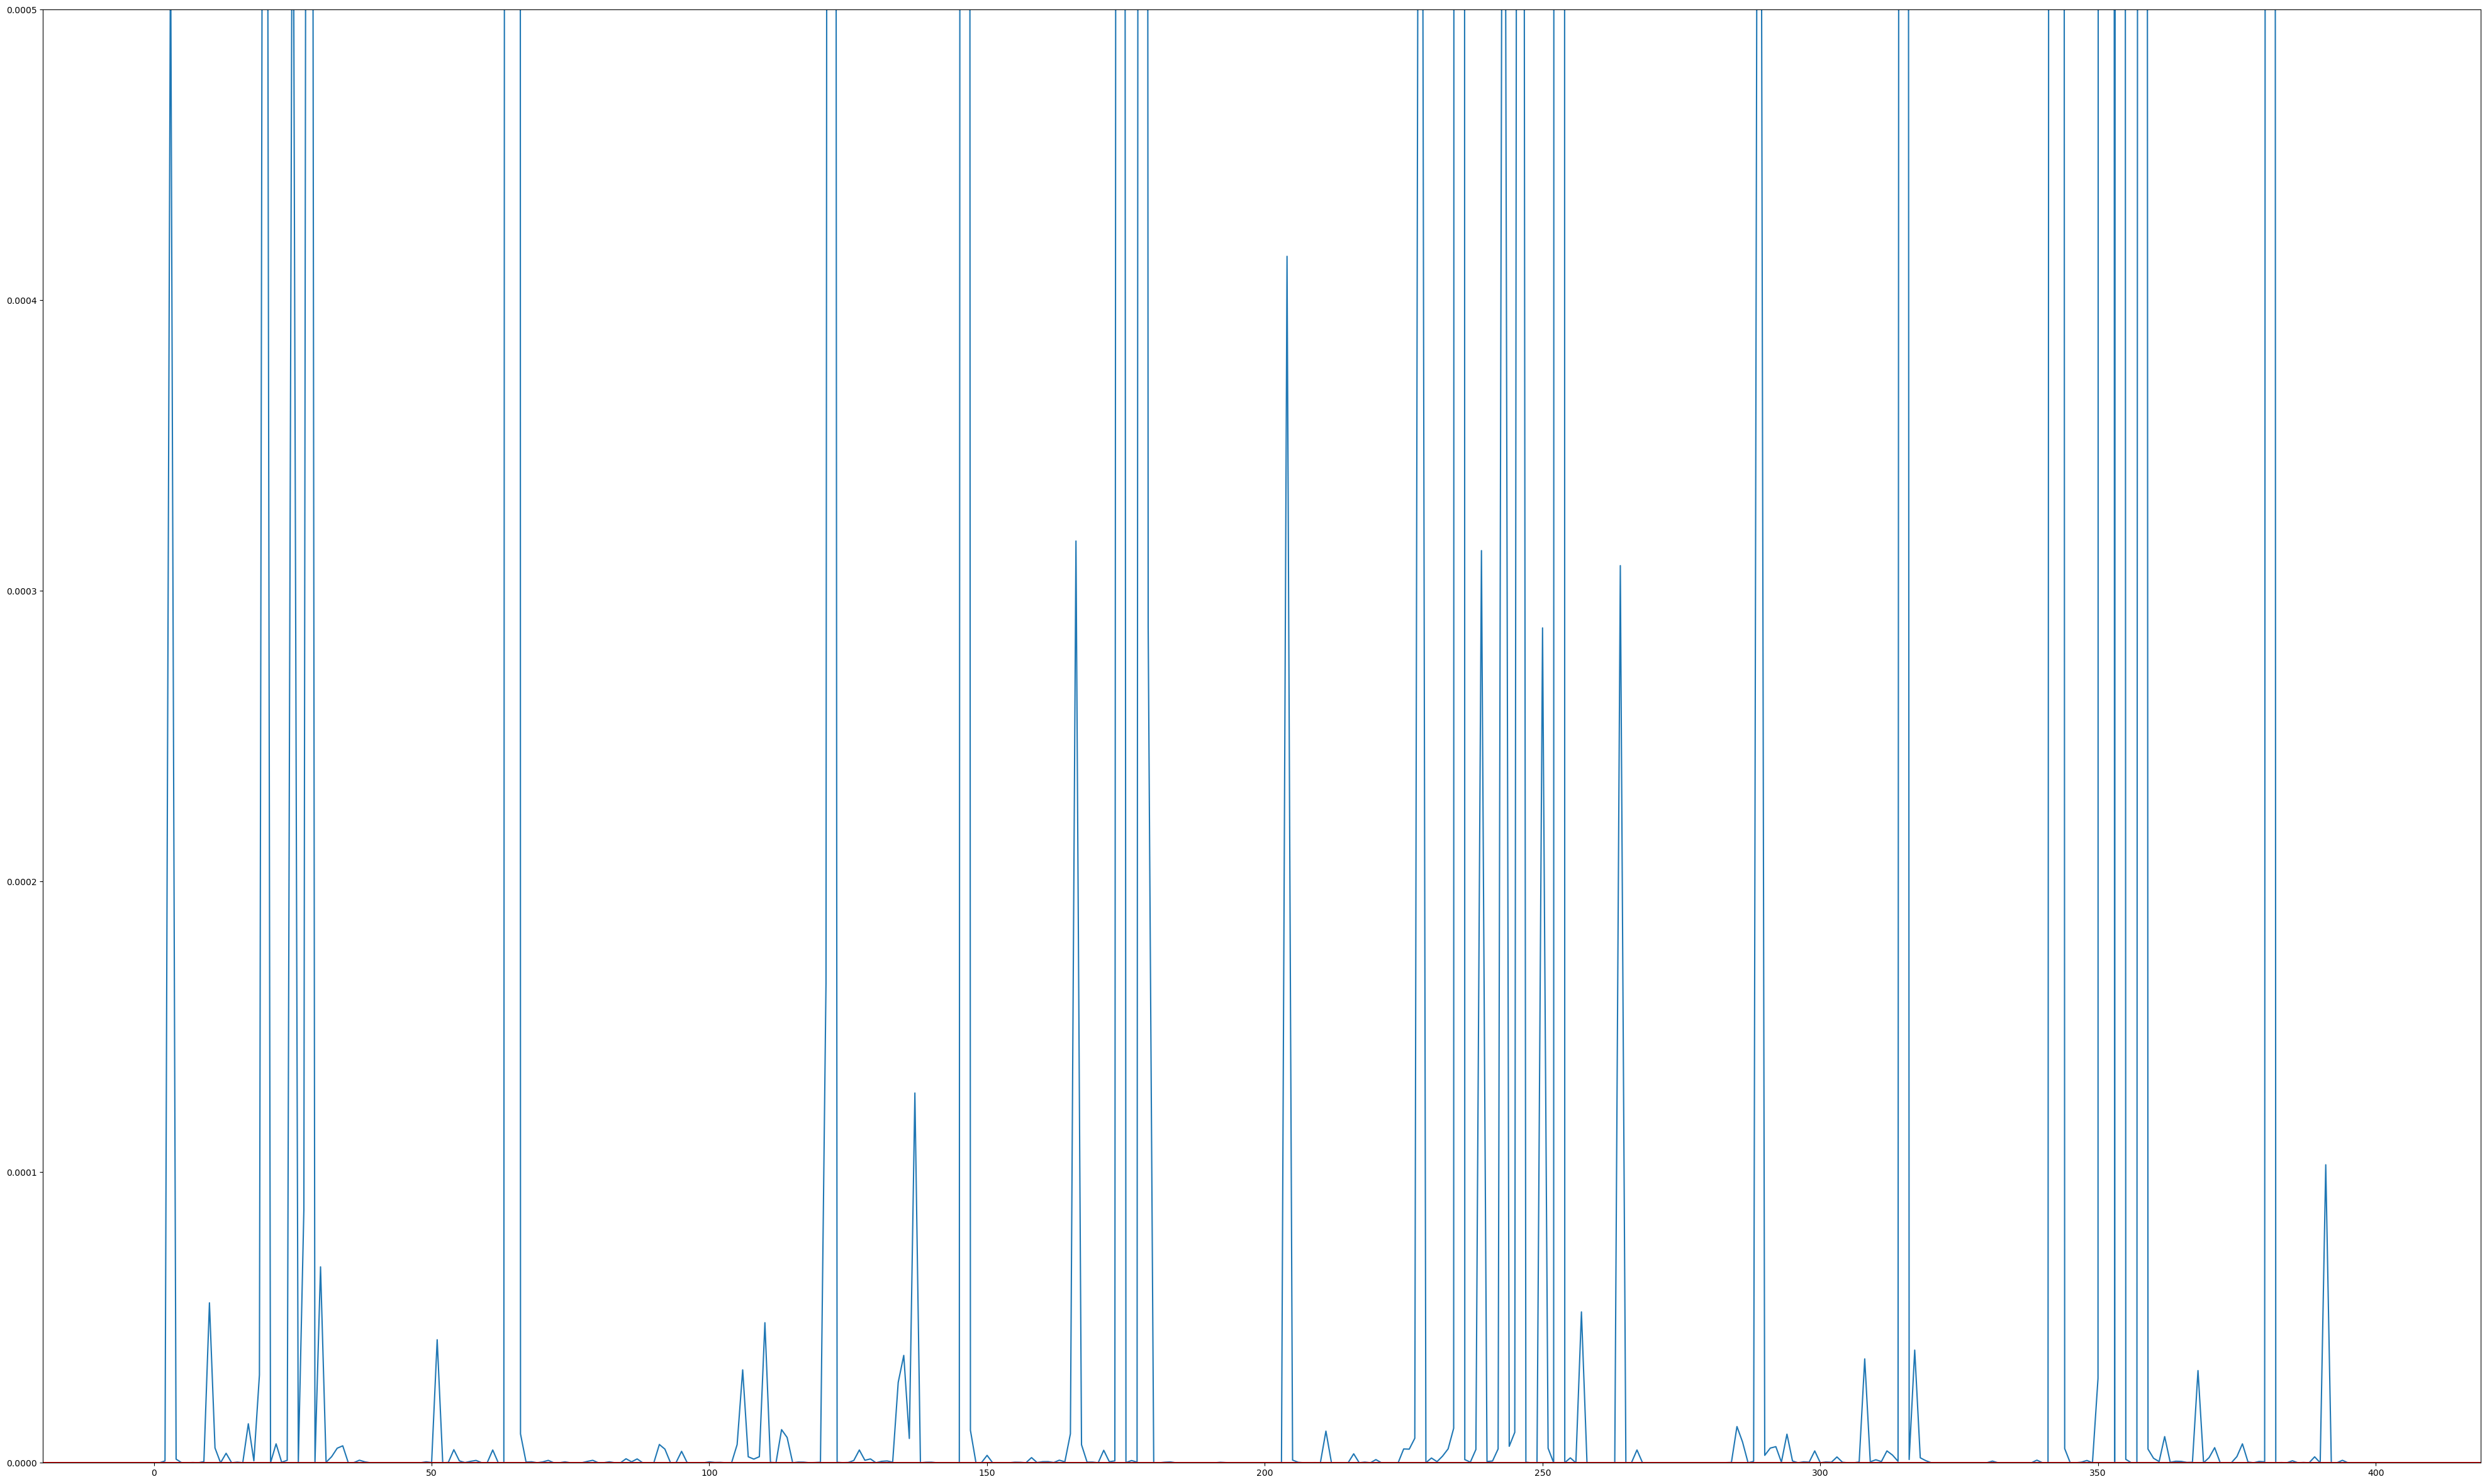

In [59]:
plt.figure(figsize=(50,30))
plt.plot(mse_list_normal)
plt.axhline(best_thr, color='r')
plt.ylim([0,0.0005])
plt.show()
plt.figure(figsize=(50,30))
plt.plot(mse_list_val_anomaly)
plt.ylim([0,0.0005])
plt.axhline(best_thr, color='r')
plt.show()


Confusion matrix
[2706 101]
[56 67]
Detect Anomaly in Test Data : 67 / Whole Test Data 123 
Precision : 0.39881
Sensitivity : 0.96402
False-Positive Rate : 0.03598


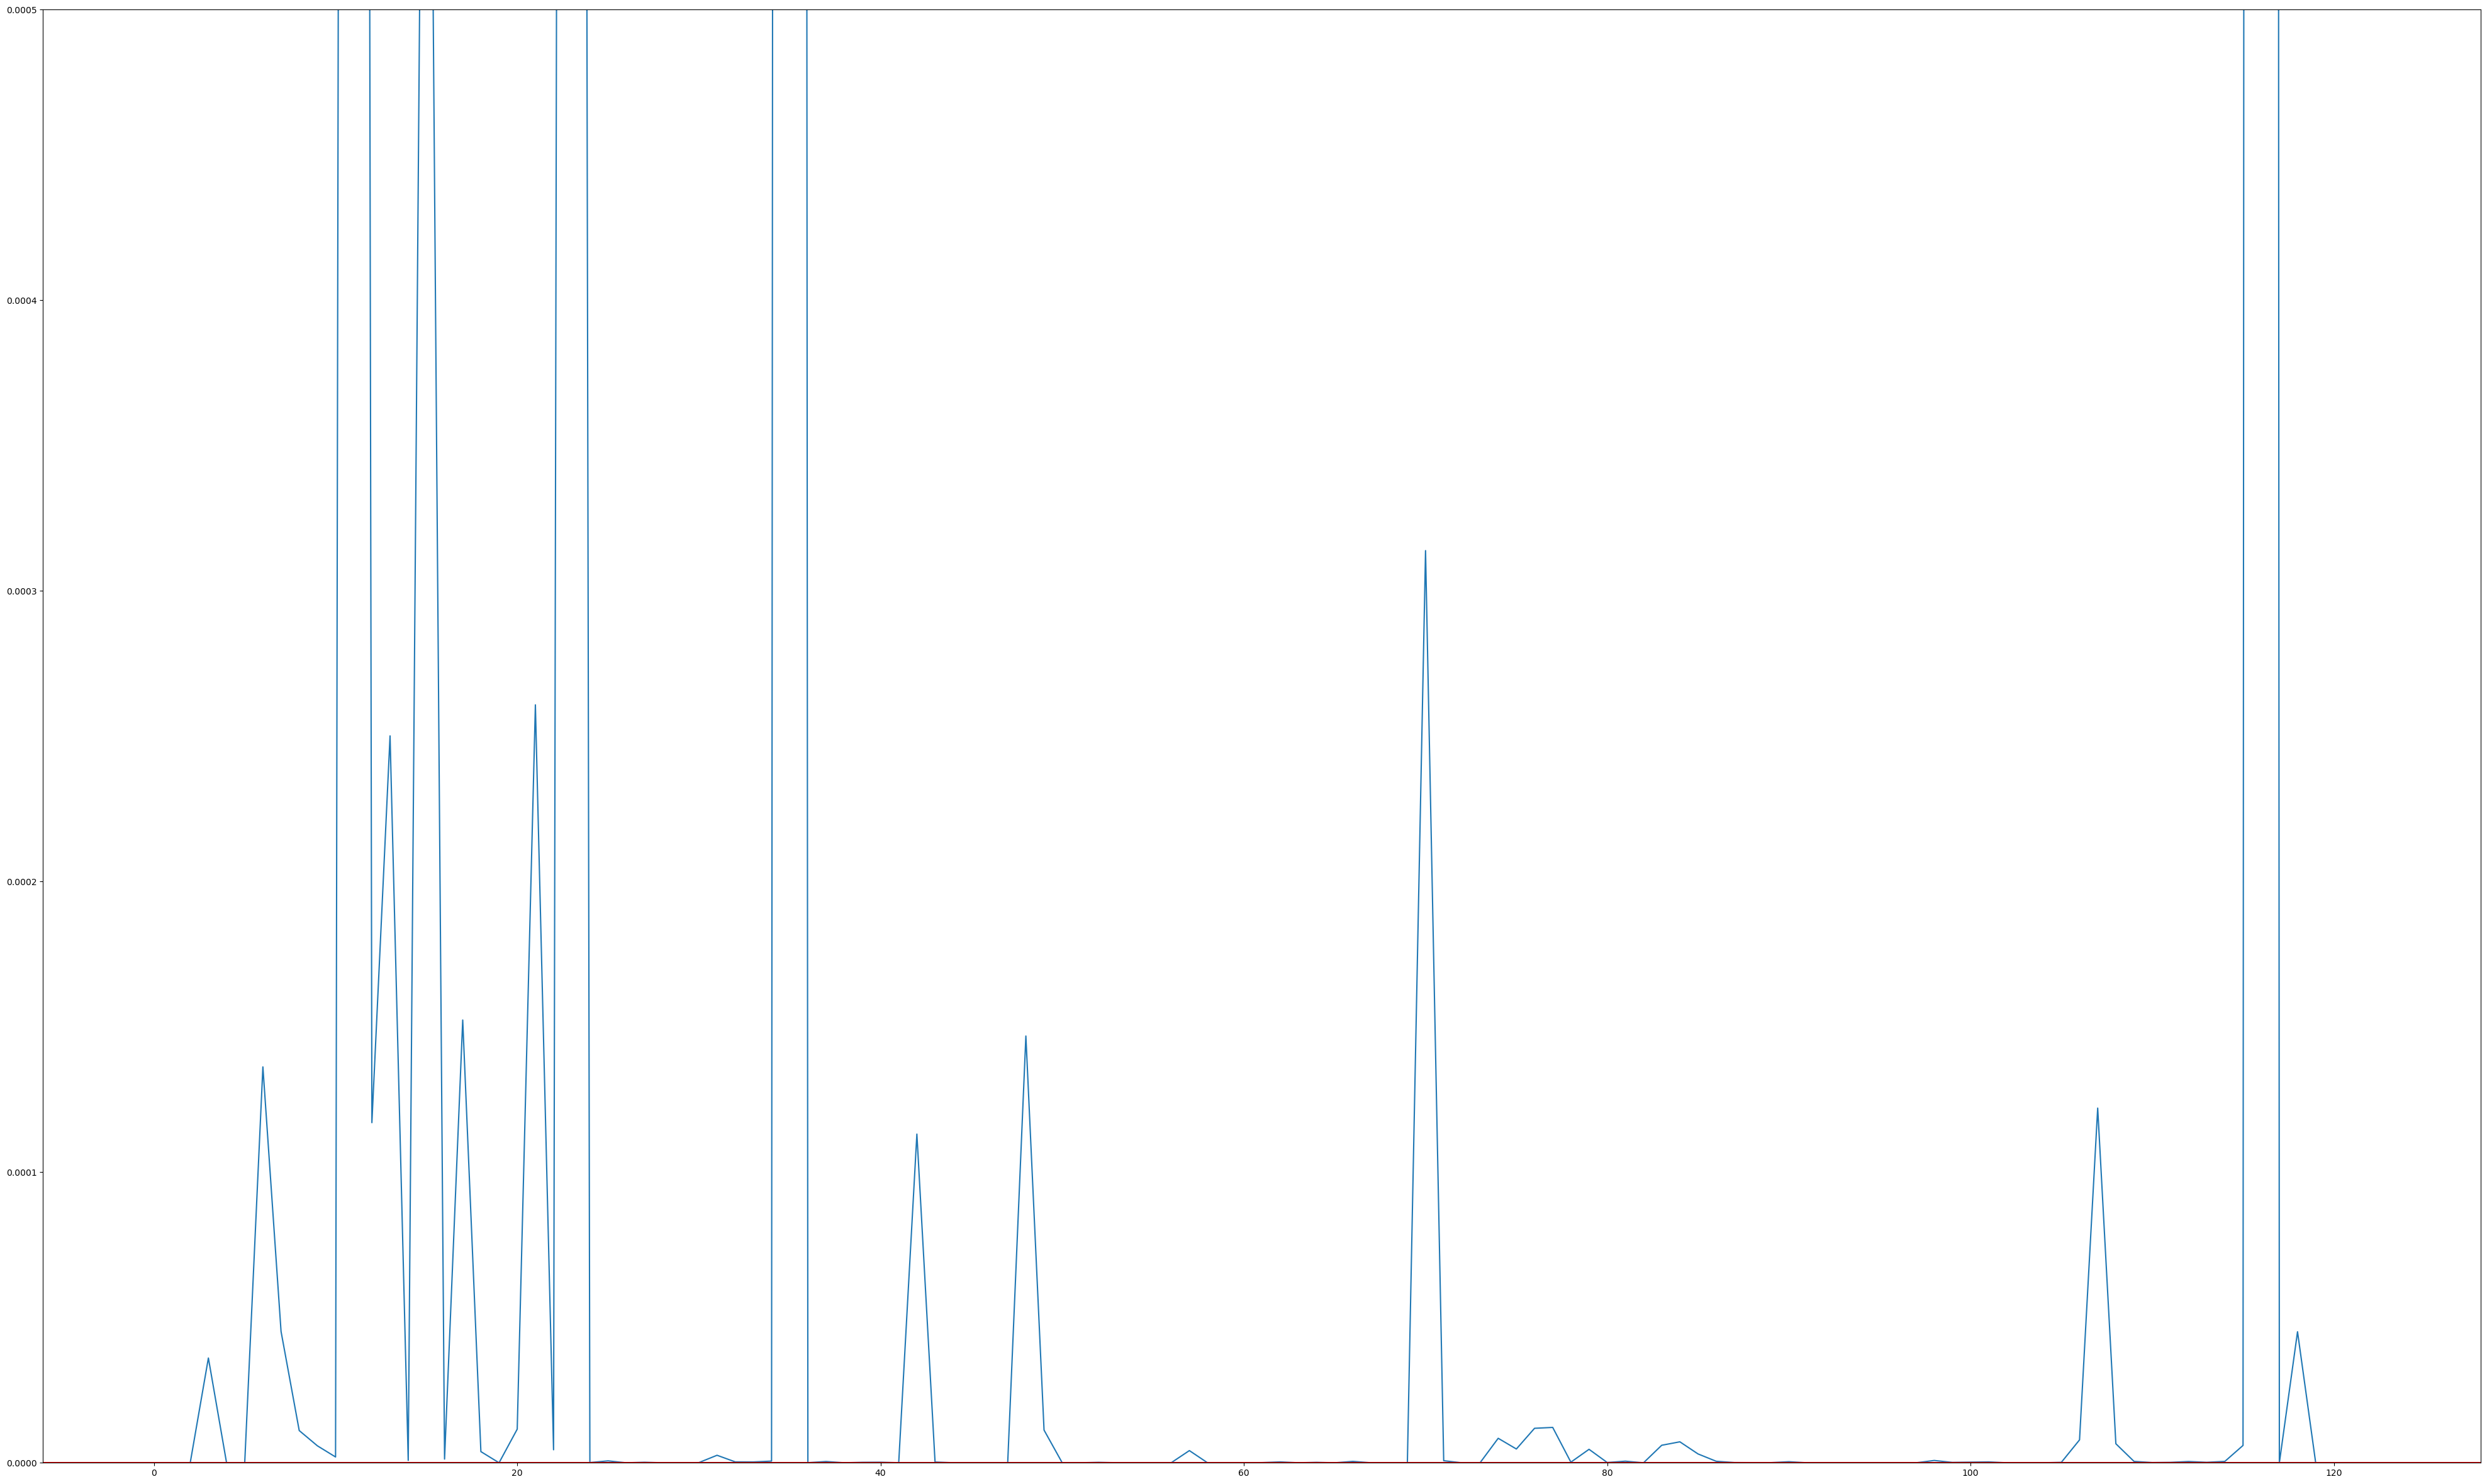

In [60]:
test_anomaly_count = 0
test_normal_count = 0
test_false_positive = 0
for i in range(len(mse_list_test_anomaly)):
    if mse_list_test_anomaly[i] > best_thr:
        test_anomaly_count = test_anomaly_count+1
for i in range(len(mse_list_test_normal)):
    if mse_list_test_normal[i] > best_thr:
        test_false_positive = test_false_positive + 1
        

        
print("Confusion matrix")
print(f"[{len(mse_list_test_normal)-test_false_positive} {test_false_positive}]\n[{len(mse_list_test_anomaly)-test_anomaly_count} {test_anomaly_count}]")
print(f"Detect Anomaly in Test Data : {str(test_anomaly_count)} / Whole Test Data {str(len(mse_list_test_anomaly))} ")
print(f"Precision : {test_anomaly_count/(test_anomaly_count + test_false_positive):.5f}")
print(f"Sensitivity : {1-test_false_positive/len(mse_list_test_normal):.5f}")
print(f"False-Positive Rate : {test_false_positive/len(mse_list_test_normal):.5f}")
plt.figure(figsize=(50,30))
plt.plot(mse_list_test_anomaly)
plt.ylim([0,0.0005])
plt.axhline(best_thr, color='r')
plt.show()